In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime
from datetime import datetime

import tqdm
import warnings
warnings.filterwarnings(action='ignore')

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.ensemble import IsolationForest

# PyCaret
import pycaret
import pycaret.anomaly as pyano

from ano_nn_analysis import *

GPU_NUM = 0 
rank = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_NUM)
dtype = torch.double

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 146, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomal/anomaly_score/logs.log'


In [3]:
def loop(model, dataloader, optimizer=None, k=0.7):
    if not optimizer:
        torch.set_grad_enabled(False)
    
    losses = []
    m0 = 0
    for batch_idx, (x_sample, y_sample, ano_score) in enumerate(dataloader):
        x_sample = x_sample.to(rank)
        y_sample = y_sample.to(rank)
        ano_score = torch.exp(-ano_score.to(rank) * k)
                
        if optimizer:
            optimizer.zero_grad()

        pred = model(x_sample)
        loss = torch.sum((pred - y_sample) ** 2 * ano_score)
        loss /= x_sample.size(0)
        losses.append(loss.item())
                
        if optimizer:
            loss.backward()
            optimizer.step()
            
    if not optimizer:
        torch.set_grad_enabled(True)
        
    return np.mean(losses)

In [4]:
# ---------------------------------------------------------------------------------
# 1) LOAD DATA
# ---------------------------------------------------------------------------------
data = pd.read_pickle('krx_data_5Y.pkl')

# ---------------------------------------------------------------------------------
# 2) PRE-PROCESSING
# ---------------------------------------------------------------------------------
data['종가'] = pd.to_numeric(data['종가'], errors='coerce')
data['주식가격'] = pd.to_numeric(data['주식가격'], errors='coerce')
data['행사가'] = pd.to_numeric(data['행사가'], errors='coerce')
data['잔존만기'] = pd.to_numeric(data['잔존만기'], errors='coerce')
data['rate'] = pd.to_numeric(data['rate'], errors='coerce')

# simple moneyness 계산
data['simple moneyness'] = data['주식가격'] / data['행사가']

# S - Ke^(-rT) 계산
data['parity'] = data['주식가격'] - (data['행사가'] * np.exp(-(data['rate'] / 100) * data['잔존만기']))

# 풋옵션 가격 (분류=1 이면 풋옵션, 분류=0 이면 콜옵션 가정)
data['put_price'] = data.apply(lambda row: row['종가'] - row['parity'] if row['분류'] == 1 else row['종가'], axis=1)

# 콜옵션 가격
data['call_price'] = data.apply(lambda row: row['종가'] + row['parity'] if row['분류'] == 0 else row['종가'], axis=1)

# 풋옵션 가격이 0보다 작은 경우 0으로 설정
data['put_price'] = np.where((data['분류'] == 1) & (data['put_price'] < 0), 0, data['put_price'])

# 최종 종가를 put_price 컬럼으로 업데이트
data['종가'] = data['put_price']

# 필요한 컬럼만 선택
data = data[['today', '거래량', '미결제약정', 'simple moneyness', '잔존만기', 'rate', 'kvix', '종가']]

data.set_index('today', inplace=True)
data.dropna(how='any', inplace=True)

In [5]:
data.shape

(346675, 7)

In [6]:
data.head(10)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2019-01-02,3,38,0.853653,0.464286,1.964,19.74,42.434170
2019-01-02,1,1090,0.826336,0.126984,1.964,19.74,53.501606
2019-01-02,7,549,0.800713,0.206349,1.964,19.74,62.985650
2019-01-02,3,3,0.882838,0.285714,1.964,19.74,33.313254
2019-01-02,924,2273,0.860767,0.126984,1.964,19.74,41.042742
2019-01-02,9,4171,0.993192,0.206349,1.964,19.74,8.318431
2019-01-02,3635,3509,0.914088,0.126984,1.964,19.74,23.866332
2019-01-02,286,10239,0.860767,0.464286,1.964,19.74,40.096863
2019-01-02,4,47,0.846656,0.722222,1.964,19.74,44.404283


In [7]:
EPOCHS = 400

### First Data Time Spilt 
- training : 19.1.1 ~ 20.12.31
- test : 20.1.1 ~ 20.06.30

In [8]:
# ---------------------------------------------------------------------------------
# 3) SPLIT DATA (train/val/test) FOR INITIAL MODEL
# ---------------------------------------------------------------------------------
data1 = data.copy()
train_val_period = (data1.index >= '2019-01-01') & (data1.index <= '2019-12-31')
test_period = (data1.index >= '2020-01-01') & (data1.index <= '2020-06-30')

data_train_val = data1[train_val_period]
data_test = data1[test_period]

In [9]:
data_train_val.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2019-01-02,3,38,0.853653,0.464286,1.964,19.74,42.434170
2019-01-02,1,1090,0.826336,0.126984,1.964,19.74,53.501606
2019-01-02,7,549,0.800713,0.206349,1.964,19.74,62.985650
2019-01-02,3,3,0.882838,0.285714,1.964,19.74,33.313254
2019-01-02,924,2273,0.860767,0.126984,1.964,19.74,41.042742


In [10]:
data_test.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2020-01-02,4,94,0.893385,0.281746,1.405,15.4,33.866020
2020-01-02,173,514,0.853971,0.202381,1.405,15.4,48.724599
2020-01-02,327,3131,1.095660,0.202381,1.405,15.4,1.090000
2020-01-02,2,21807,1.262391,0.976190,1.405,15.4,2.220000
2020-01-02,10,3991,0.784730,0.976190,1.405,15.4,75.189916


In [11]:
data_train_val = data_train_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data1 = data_train_val.copy()

In [12]:
# ---------------------------------------------------------------------------------
# 4) PYCARET ANOMALY DETECTION
# ---------------------------------------------------------------------------------
exp_ano = pyano.setup(data=data1, use_gpu=True, session_id=31)
ml_model = pyano.create_model('iforest')      # Isolation Forest
data_ano = pyano.assign_model(ml_model)       # Anomaly detection result
data_ano1 = data_ano.copy()

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 146, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomal/anomaly_score/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(60665, 7)"
2,Transformed data shape,"(60665, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
# ---------------------------------------------------------------------------------
# 5) TRAIN/VAL SPLIT FOR PYTORCH (BASIC)
# ---------------------------------------------------------------------------------
x = data_ano1.drop(['종가'], axis=1)
y = data_ano1[['종가']]

# Scale specific columns
x['rate'] *= 0.01
x['kvix'] *= 0.01
scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Separate anomaly columns
as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly','Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly','Anomaly_Score'], axis=1)

# Convert to torch tensors
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch   = torch.from_numpy(x_val.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch   = torch.from_numpy(y_val.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch   = torch.from_numpy(as_val.values).float()

# Create datasets/dataloaders
dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val   = TensorDataset(x_val_torch,   y_val_torch,   as_val_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val   = DataLoader(dataset_val,   batch_size=64, shuffle=True, num_workers=8, drop_last=True)

In [12]:
# ---------------------------------------------------------------------------------
# 6) TRAIN MODELS SEPARATELY (k=0.0 and k=0.7)
# ---------------------------------------------------------------------------------

# 모델 및 학습 설정
model_k0 = NN(x_train.shape[1]).to(rank)  # k=0.0 모델
model_k7 = NN(x_train.shape[1]).to(rank)  # k=0.7 모델

optimizer_k0 = torch.optim.Adam(model_k0.parameters(), lr=0.005)
optimizer_k7 = torch.optim.Adam(model_k7.parameters(), lr=0.005)

early_stopping_k0 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)
early_stopping_k7 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)

# -----------------------------
# 1. Train Model (k=0.0)
# -----------------------------
loss_list_k0 = np.zeros((EPOCHS, 2))
best_model_wts_k0 = None
best_val_loss_k0 = float('inf')

print("\n[k=0.0 모델 학습 시작]\n")
torch.set_grad_enabled(True)
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.0"):
    model_k0.train()
    train_mse_k0 = loop(model_k0, dataloader_train, optimizer_k0, k=0.0)

    model_k0.eval()
    val_mse_k0 = loop(model_k0, dataloader_val, k=0.0)

    # 손실 기록
    loss_list_k0[epoch, 0] = train_mse_k0
    loss_list_k0[epoch, 1] = val_mse_k0

    # 최적 가중치 저장
    if val_mse_k0 < best_val_loss_k0:
        best_val_loss_k0 = val_mse_k0
        best_model_wts_k0 = model_k0.state_dict()

    #scheduler_k0.step()
    early_stopping_k0(val_mse_k0, epoch)
    if early_stopping_k0.early_stop:
        print(f"[k=0.0] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.0)
if best_model_wts_k0 is not None:
    torch.save(best_model_wts_k0, '1st_best_model_k0.pth')
    print("[k=0.0] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.0] 모델이 저장되지 않았습니다.")

# -----------------------------
# 2. Train Model (k=0.7)
# -----------------------------
loss_list_k7 = np.zeros((EPOCHS, 2))
best_model_wts_k7 = None
best_val_loss_k7 = float('inf')

print("\n[k=0.7 모델 학습 시작]\n")
torch.set_grad_enabled(True)
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.5"):
    model_k7.train()
    train_mse_k7 = loop(model_k7, dataloader_train, optimizer_k7, k=0.5)

    model_k7.eval()
    val_mse_k7 = loop(model_k7, dataloader_val, k=0.7)

    # 손실 기록
    loss_list_k7[epoch, 0] = train_mse_k7
    loss_list_k7[epoch, 1] = val_mse_k7

    # 최적 가중치 저장
    if val_mse_k7 < best_val_loss_k7:
        best_val_loss_k7 = val_mse_k7
        best_model_wts_k7 = model_k7.state_dict()

    #scheduler_k7.step()
    early_stopping_k7(val_mse_k7, epoch)
    if early_stopping_k7.early_stop:
        print(f"[k=0.7] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.7)
if best_model_wts_k7 is not None:
    torch.save(best_model_wts_k7, '1st_best_model_k7.pth')
    print("[k=0.7] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.7] 모델이 저장되지 않았습니다.")



[k=0.0 모델 학습 시작]



Training k=0.0:  99%|█████████▉| 397/400 [2:04:16<00:56, 18.78s/it]  


[k=0.0] 조기 종료 (epoch 397)
[k=0.0] 최적의 모델이 저장되었습니다.

[k=0.7 모델 학습 시작]



Training k=0.7:  96%|█████████▌| 384/400 [2:02:00<05:05, 19.06s/it]  

[k=0.7] 조기 종료 (epoch 384)
[k=0.7] 최적의 모델이 저장되었습니다.


In [14]:
# ---------------------------------------------------------------------------------
# 7) TEST PHASE (BASIC)
# ---------------------------------------------------------------------------------
data_test1 = data_test.copy()
x_test = data_test1.drop(['종가'], axis=1)
y_test = data_test1[['종가']]

x_test['rate'] *= 0.01
x_test['kvix'] *= 0.01
x_test[['거래량', '미결제약정']] = scaler.transform(x_test[['거래량', '미결제약정']])

x_test_torch = torch.from_numpy(x_test.values).float().to(rank)
y_test_torch = torch.from_numpy(y_test.values).float().to(rank)

dataset_test = TensorDataset(x_test_torch, y_test_torch)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=0, drop_last=True)

In [18]:
np.mean(y_test)

종가    24.716368
dtype: float64

In [91]:
# -----------------------------
# Load best weights for inference (from file)
# -----------------------------
model_k0 = NN(x_test.shape[1]).to(rank)  
model_k0.load_state_dict(torch.load('1st_best_model_k0.pth'))  
model_k0.eval()  
test_pred = []
y_result = []

with torch.no_grad():
    for batch_idx, samples in enumerate(dataloader_test):
        x_sample, y_sample = samples
        x_sample = x_sample.to(rank)
        y_sample = y_sample.to(rank)
        pred = model_k0(x_sample)  # model_k0로 예측
        test_pred = np.concatenate((pred.detach().cpu().numpy()))
        y_result = np.concatenate((y_sample.detach().cpu().numpy()))

# Calculate MAE and MSE
mae = np.mean(np.abs(test_pred - y_result))
mse = np.mean((test_pred - y_result)**2)
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  2.0671704
MSE:  7.191503


In [93]:
# -----------------------------
# Load best weights for inference (from file)
# -----------------------------
model_k7 = NN(x_test.shape[1]).to(rank)  
model_k7.load_state_dict(torch.load('1st_best_model_k7.pth'))  
model_k7.eval()  
test_pred = []
y_result = []

with torch.no_grad():
    for batch_idx, samples in enumerate(dataloader_test):
        x_sample, y_sample = samples
        x_sample = x_sample.to(rank)
        y_sample = y_sample.to(rank)
        pred = model_k7(x_sample)  # model_k0로 예측
        test_pred = np.concatenate((pred.detach().cpu().numpy()))
        y_result = np.concatenate((y_sample.detach().cpu().numpy()))

# Calculate MAE and MSE
mae = np.mean(np.abs(test_pred - y_result))
mse = np.mean((test_pred - y_result)**2)
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  4.183836
MSE:  24.273222


In [15]:
# ---------------------------------------------------------------------------------
# 8) ADDITIONAL CODE: Classify by Option Type (ITM / OTM / ATM)
# ---------------------------------------------------------------------------------
data_ano1 = data_ano.copy()
data_ano1 = data_ano1.reset_index()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify) 
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

x_test['mn_class'] = data_ano1.loc[x_test.index, 'mn_class']

# Split into ITM, OTM, ATM subsets
itm_data = x_test[x_test['mn_class'] == 0].drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1].drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2].drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]

print("ITM/OTM/ATM shapes:")
print(itm_data.shape, otm_data.shape, atm_data.shape)

# Percentage
per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] / x_test.shape[0]) * 100
per3 = (atm_data.shape[0] / x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%")

# Build dataloaders
itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

# Drop the 'mn_class' column from x_test after use
x_test = x_test.drop(['mn_class'], axis=1)

# ---------------------------------------------------------------------------------
# 9) ADDITIONAL CODE: Classify by Trade Frequency (Very High / High / Low / Very Low)
# ---------------------------------------------------------------------------------
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)

class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

# Attach 'freq' to x_test
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

vhf_data = x_test[x_test['freq'] == 0].drop(['freq'], axis=1)
hf_data  = x_test[x_test['freq'] == 1].drop(['freq'], axis=1)
lf_data  = x_test[x_test['freq'] == 2].drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3].drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y  = y_test.loc[hf_data.index]
lf_y  = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]

print("ITM/OTM/ATM shapes (again for reference):")
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] / x_test.shape[0]) * 100
per3 = (lf_data.shape[0] / x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] / x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}%, VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader  = create_dataloader(hf_data,  hf_y)
lf_dataloader  = create_dataloader(lf_data,  lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

# Drop 'freq' from x_test
x_test = x_test.drop(['freq'], axis=1)

# ---------------------------------------------------------------------------------
# 10) ADDITIONAL CODE: Classify by Time to Expiry (biweek / onemonth / quarter / half / year)
# ---------------------------------------------------------------------------------
data_ano3 = data_ano.copy()

def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825:  # ~1 month
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else:
        return 'year'
    
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)

print(data_ano3[['expiry']].sample(10))

# Attach 'expiry' to x_test
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

b_data = x_test[x_test['expiry'] == 0].drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1].drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2].drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3].drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4].drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
yy_y = y_test.loc[y_data.index] 

print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] / x_test.shape[0]) * 100
per3 = (q_data.shape[0] / x_test.shape[0]) * 100
per4 = (h_data.shape[0] / x_test.shape[0]) * 100
per5 = (y_data.shape[0] / x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}%, OneMonth {per2:.4f}%, Quarter {per3:.4f}%, Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
yy_dataloader = create_dataloader(y_data, yy_y)

# Drop 'expiry' from x_test after use
x_test = x_test.drop(['expiry'], axis=1)

ITM/OTM/ATM shapes:
(12270, 6) (13671, 6) (7438, 6)
itm 36.7596% , otm 40.9569%, atm 22.2835%
      freq
29387    0
710      3
20526    3
52809    3
2979     2
40323    2
28354    2
39316    3
19981    0
28943    2
ITM/OTM/ATM shapes (again for reference):
(12270, 6) (13671, 6) (7438, 6)
VeryHighFreq 19.7759% , HighFreq 20.2043%, LowFreq 28.7546%, VeryLowFreq 31.2652%
       expiry
24940       1
18380       3
36008       3
16940       4
33047       2
9312        2
52203       3
14137       2
35212       2
55665       3
(480, 6) (3795, 6) (14616, 6) (8802, 6) (5686, 6)
Bi week 1.4380%, OneMonth 11.3694%, Quarter 43.7880%, Half 26.3699%, Year 17.0347%


In [16]:
# ---------------------------------------------------------------------------------
# 11) EXAMPLE: Load Pretrained Models (k=0.0 vs k=0.7) and Evaluate on Sub-Dataloaders
# ---------------------------------------------------------------------------------
# (Re-)split the data_ano for a complete pipeline demonstration
x = data_ano.drop(['종가'], axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량', '미결제약정']])
x[['거래량', '미결제약정']] = scaler.transform(x[['거래량', '미결제약정']])

# Train/test split
x_train, x_test_final, y_train, y_test_final = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_test = x_test_final[['Anomaly_Score']]
x_test_final = x_test_final.drop(['Anomaly', 'Anomaly_Score'], axis=1)

print("Shapes:")
print(x_train.shape, x_val.shape, x_test_final.shape,
      y_train.shape, y_val.shape, y_test_final.shape,
      as_train.shape, as_val.shape, as_test.shape)

# Convert to Torch
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch = torch.from_numpy(x_val.values).float()
x_test_torch = torch.from_numpy(x_test_final.values).float()

y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch = torch.from_numpy(y_val.values).float()
y_test_torch = torch.from_numpy(y_test_final.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch = torch.from_numpy(as_val.values).float()
as_test_torch = torch.from_numpy(as_test.values).float()

dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch, as_val_torch)
dataset_test = TensorDataset(x_test_torch, y_test_torch, as_test_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=8, drop_last=True)

# Optionally gather your specialized test dataloaders in a dict
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, yy_dataloader]
}

# -----------------------------
# Load Pretrained Models (k=0.0 and k=0.7)
# -----------------------------
print("\n[가중치 로드 및 테스트 시작]\n")

# Load the basic model (k=0.0)
model_basic = NN(x_train.shape[1]).to(rank)
model_basic.load_state_dict(torch.load('1st_best_model_k0.pth'))  # Load saved weights
model_basic.eval()

# Load the anomaly-weighted model (k=0.7)
model_ano = NN(x_train.shape[1]).to(rank)
model_ano.load_state_dict(torch.load('1st_best_model_k7.pth'))  # Load saved weights
model_ano.eval()

# -----------------------------
# Evaluate Models on Each Sub-Dataloader
# -----------------------------
mse_values_k0_list = []
mse_values_k7_list = []

for key, tloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(model_basic, dataloader_test, tloaders, rank)  # k=0.0 모델 평가
    mse_values_k7 = evaluate_model(model_ano, dataloader_test, tloaders, rank)  # k=0.7 모델 평가

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model ({key}): {mse_values_k0}")
    print(f"MSE values for ano model   ({key}): {mse_values_k7}")

print("Done.")


Shapes:
(38825, 6) (9707, 6) (12133, 6) (38825, 1) (9707, 1) (12133, 1) (38825, 1) (9707, 1) (12133, 1)

[가중치 로드 및 테스트 시작]

MSE values for basic model (option_type): [1.0213733028052032, 317.74911823534563, 388.33488591540174, 334.3338742962477]
MSE values for ano model   (option_type): [0.7400231258489104, 103.1689546204753, 123.1097309632178, 107.95087396716927]
MSE values for basic model (freq): [1.0213733028052032, 334.50110430619895, 363.05697922652763, 365.9245826068915, 337.8536854947079]
MSE values for ano model   (freq): [0.7400231258489104, 108.595683677507, 117.0384885404338, 116.74523349877906, 107.81778267209631]
MSE values for basic model (maturity): [1.0213733028052032, 1206.093915724408, 276.27884512789416, 378.7502739763408, 309.22096153468334, 318.2383148853471]
MSE values for ano model   (maturity): [0.7400231258489104, 406.3676895669126, 89.86337794772682, 120.51105680299258, 99.8532020571552, 101.20810846215724]
Done.


### Second Data Time Spilt 
- training : 19.7.1 ~ 20.6.30
- test : 20.7.1 ~ 20.12.31

In [17]:
# ---------------------------------------------------------------------------------
# 3) SPLIT DATA (train/val/test) FOR INITIAL MODEL
# ---------------------------------------------------------------------------------
data1 = data.copy()
train_val_period = (data1.index >= '2019-07-01') & (data1.index <= '2020-06-30')
test_period = (data1.index >= '2020-07-01') & (data1.index <= '2020-12-31')

data_train_val = data1[train_val_period]
data_test = data1[test_period]

In [18]:
data_train_val.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2019-07-01,10,14281,0.956103,0.472222,1.851,14.03,15.306204
2019-07-01,58,4393,0.909082,0.472222,1.851,14.03,26.875663
2019-07-01,4,3165,1.320333,0.988095,1.851,14.03,1.440000
2019-07-01,8,3554,0.990250,0.214286,1.851,14.03,7.151600
2019-07-01,109,7754,1.046302,0.214286,1.851,14.03,2.270000


In [19]:
data_test.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2020-07-01,4,1403,1.245600,0.206349,0.476,29.9,1.72
2020-07-01,29,113,1.751625,0.464286,0.476,29.9,1.10
2020-07-01,10,67,1.514919,0.206349,0.476,29.9,0.63
2020-07-01,186,344,1.455896,0.126984,0.476,29.9,0.34
2020-07-01,2,280,1.419038,0.206349,0.476,29.9,0.83


In [20]:
data_train_val = data_train_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data1 = data_train_val.copy()

In [21]:
# ---------------------------------------------------------------------------------
# 4) PYCARET ANOMALY DETECTION
# ---------------------------------------------------------------------------------
exp_ano = pyano.setup(data=data1, use_gpu=True, session_id=31, index=False)
ml_model = pyano.create_model('iforest')      # Isolation Forest
data_ano = pyano.assign_model(ml_model)       # Anomaly detection result
data_ano1 = data_ano.copy()

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 144, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomaly/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(63826, 7)"
2,Transformed data shape,"(63826, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
# ---------------------------------------------------------------------------------
# 5) TRAIN/VAL SPLIT FOR PYTORCH (BASIC)
# ---------------------------------------------------------------------------------
x = data_ano1.drop(['종가'], axis=1)
y = data_ano1[['종가']]

# Scale specific columns
x['rate'] *= 0.01
x['kvix'] *= 0.01
scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Separate anomaly columns
as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly','Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly','Anomaly_Score'], axis=1)

# Convert to torch tensors
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch   = torch.from_numpy(x_val.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch   = torch.from_numpy(y_val.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch   = torch.from_numpy(as_val.values).float()

# Create datasets/dataloaders
dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val   = TensorDataset(x_val_torch,   y_val_torch,   as_val_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val   = DataLoader(dataset_val,   batch_size=64, shuffle=True, num_workers=8, drop_last=True)

In [24]:
# ---------------------------------------------------------------------------------
# 6) TRAIN MODELS SEPARATELY (k=0.0 and k=0.7)
# ---------------------------------------------------------------------------------

# 모델 및 학습 설정
model_k0 = NN(x_train.shape[1]).to(rank)  # k=0.0 모델
model_k7 = NN(x_train.shape[1]).to(rank)  # k=0.7 모델

optimizer_k0 = torch.optim.Adam(model_k0.parameters(), lr=0.005)
optimizer_k7 = torch.optim.Adam(model_k7.parameters(), lr=0.005)

# scheduler_k0 = CosineAnnealingWarmUpRestarts(optimizer_k0, T_0=100, T_mult=1, eta_max=0.1, T_up=10, gamma=0.5)
# scheduler_k7 = CosineAnnealingWarmUpRestarts(optimizer_k7, T_0=100, T_mult=1, eta_max=0.1, T_up=10, gamma=0.5)

early_stopping_k0 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)
early_stopping_k7 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)

# -----------------------------
# 1. Train Model (k=0.0)
# -----------------------------
loss_list_k0 = np.zeros((EPOCHS, 2))
best_model_wts_k0 = None
best_val_loss_k0 = float('inf')

print("\n[k=0.0 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.0"):
    model_k0.train()
    train_mse_k0 = loop(model_k0, dataloader_train, optimizer_k0, k=0.0)

    model_k0.eval()
    val_mse_k0 = loop(model_k0, dataloader_val, k=0.0)

    # 손실 기록
    loss_list_k0[epoch, 0] = train_mse_k0
    loss_list_k0[epoch, 1] = val_mse_k0

    # 최적 가중치 저장
    if val_mse_k0 < best_val_loss_k0:
        best_val_loss_k0 = val_mse_k0
        best_model_wts_k0 = model_k0.state_dict()

    # scheduler_k0.step()
    early_stopping_k0(val_mse_k0, epoch)
    if early_stopping_k0.early_stop:
        print(f"[k=0.0] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.0)
if best_model_wts_k0 is not None:
    torch.save(best_model_wts_k0, '2nd_best_model_k0.pth')
    print("[k=0.0] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.0] 모델이 저장되지 않았습니다.")

# -----------------------------
# 2. Train Model (k=0.7)
# -----------------------------
loss_list_k7 = np.zeros((EPOCHS, 2))
best_model_wts_k7 = None
best_val_loss_k7 = float('inf')

print("\n[k=0.7 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.7"):
    model_k7.train()
    train_mse_k7 = loop(model_k7, dataloader_train, optimizer_k7, k=0.7)

    model_k7.eval()
    val_mse_k7 = loop(model_k7, dataloader_val, k=0.7)

    # 손실 기록
    loss_list_k7[epoch, 0] = train_mse_k7
    loss_list_k7[epoch, 1] = val_mse_k7

    # 최적 가중치 저장
    if val_mse_k7 < best_val_loss_k7:
        best_val_loss_k7 = val_mse_k7
        best_model_wts_k7 = model_k7.state_dict()

    # scheduler_k7.step()
    early_stopping_k7(val_mse_k7, epoch)
    if early_stopping_k7.early_stop:
        print(f"[k=0.7] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.7)
if best_model_wts_k7 is not None:
    torch.save(best_model_wts_k7, '2nd_best_model_k7.pth')
    print("[k=0.7] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.7] 모델이 저장되지 않았습니다.")



[k=0.0 모델 학습 시작]



Training k=0.0: 100%|██████████| 400/400 [2:09:35<00:00, 19.44s/it]  


[k=0.0] 최적의 모델이 저장되었습니다.

[k=0.7 모델 학습 시작]



Training k=0.7:  96%|█████████▌| 383/400 [2:03:59<05:30, 19.42s/it]  

[k=0.7] 조기 종료 (epoch 383)
[k=0.7] 최적의 모델이 저장되었습니다.


In [23]:
# ---------------------------------------------------------------------------------
# 7) TEST PHASE (BASIC)
# ---------------------------------------------------------------------------------
data_test2 = data_test.copy()
x_test = data_test2.drop(['종가'], axis=1)
y_test = data_test2[['종가']]

x_test['rate'] *= 0.01
x_test['kvix'] *= 0.01
x_test[['거래량', '미결제약정']] = scaler.transform(x_test[['거래량', '미결제약정']])

x_test_torch = torch.from_numpy(x_test.values).float().to(rank)
y_test_torch = torch.from_numpy(y_test.values).float().to(rank)

dataset_test = TensorDataset(x_test_torch, y_test_torch)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=0, drop_last=True)

In [24]:
# -----------------------------
# Load best weights for inference (from file)
# -----------------------------
model_k0 = NN(x_test.shape[1]).to(rank)  
model_k0.load_state_dict(torch.load('2nd_best_model_k0.pth'))  
model_k0.eval()  
test_pred = []
y_result = []

with torch.no_grad():
    for batch_idx, samples in enumerate(dataloader_test):
        x_sample, y_sample = samples
        x_sample = x_sample.to(rank)
        y_sample = y_sample.to(rank)
        pred = model_k0(x_sample)  # model_k0로 예측
        test_pred.append(pred.detach().cpu().numpy())
        y_result.append(y_sample.detach().cpu().numpy())

test_pred = np.concatenate(test_pred).flatten()
y_result = np.concatenate(y_result).flatten()

# Calculate MAE and MSE
mae = np.mean(np.abs(test_pred - y_result))
mse = np.mean((test_pred - y_result)**2)
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  1.5228248
MSE:  8.0554905


In [25]:
# -----------------------------
# Load best weights for inference (from file)
# -----------------------------
model_k7 = NN(x_test.shape[1]).to(rank)  
model_k7.load_state_dict(torch.load('2nd_best_model_k7.pth'))  
model_k7.eval()  
test_pred = []
y_result = []

with torch.no_grad():
    for batch_idx, samples in enumerate(dataloader_test):
        x_sample, y_sample = samples
        x_sample = x_sample.to(rank)
        y_sample = y_sample.to(rank)
        pred = model_k7(x_sample)  # model_k0로 예측
        test_pred.append(pred.detach().cpu().numpy())
        y_result.append(y_sample.detach().cpu().numpy())

test_pred = np.concatenate(test_pred).flatten()
y_result = np.concatenate(y_result).flatten()

# Calculate MAE and MSE
mae = np.mean(np.abs(test_pred - y_result))
mse = np.mean((test_pred - y_result)**2)
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  2.295063
MSE:  15.690635


In [26]:
# ---------------------------------------------------------------------------------
# 8) ADDITIONAL CODE: Classify by Option Type (ITM / OTM / ATM)
# ---------------------------------------------------------------------------------
data_ano1 = data_ano.copy()
data_ano1 = data_ano1.reset_index()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify) 
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

x_test['mn_class'] = data_ano1.loc[x_test.index, 'mn_class']

# Split into ITM, OTM, ATM subsets
itm_data = x_test[x_test['mn_class'] == 0].drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1].drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2].drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]

print("ITM/OTM/ATM shapes:")
print(itm_data.shape, otm_data.shape, atm_data.shape)

# Percentage
per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] / x_test.shape[0]) * 100
per3 = (atm_data.shape[0] / x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%")

# Build dataloaders
itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

# Drop the 'mn_class' column from x_test after use
x_test = x_test.drop(['mn_class'], axis=1)

# ---------------------------------------------------------------------------------
# 9) ADDITIONAL CODE: Classify by Trade Frequency (Very High / High / Low / Very Low)
# ---------------------------------------------------------------------------------
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)

class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

# Attach 'freq' to x_test
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

vhf_data = x_test[x_test['freq'] == 0].drop(['freq'], axis=1)
hf_data  = x_test[x_test['freq'] == 1].drop(['freq'], axis=1)
lf_data  = x_test[x_test['freq'] == 2].drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3].drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y  = y_test.loc[hf_data.index]
lf_y  = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]

print("ITM/OTM/ATM shapes (again for reference):")
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] / x_test.shape[0]) * 100
per3 = (lf_data.shape[0] / x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] / x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}%, VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader  = create_dataloader(hf_data,  hf_y)
lf_dataloader  = create_dataloader(lf_data,  lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

# Drop 'freq' from x_test
x_test = x_test.drop(['freq'], axis=1)

# ---------------------------------------------------------------------------------
# 10) ADDITIONAL CODE: Classify by Time to Expiry (biweek / onemonth / quarter / half / year)
# ---------------------------------------------------------------------------------
data_ano3 = data_ano.copy()

def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825:  # ~1 month
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else:
        return 'year'
    
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)

print(data_ano3[['expiry']].sample(10))

# Attach 'expiry' to x_test
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

b_data = x_test[x_test['expiry'] == 0].drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1].drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2].drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3].drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4].drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
yy_y = y_test.loc[y_data.index]  # note: 'y_y' might be ambiguous, rename to yy_y

print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] / x_test.shape[0]) * 100
per3 = (q_data.shape[0] / x_test.shape[0]) * 100
per4 = (h_data.shape[0] / x_test.shape[0]) * 100
per5 = (y_data.shape[0] / x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}%, OneMonth {per2:.4f}%, Quarter {per3:.4f}%, Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
yy_dataloader = create_dataloader(y_data, yy_y)

# Drop 'expiry' from x_test after use
x_test = x_test.drop(['expiry'], axis=1)

ITM/OTM/ATM shapes:
(10897, 6) (13520, 6) (7616, 6)
itm 34.0180% , otm 42.2065%, atm 23.7755%
      freq
57095    1
14191    0
3799     3
58857    3
5441     3
5970     3
19308    2
50642    3
46556    3
53606    1
ITM/OTM/ATM shapes (again for reference):
(10897, 6) (13520, 6) (7616, 6)
VeryHighFreq 17.4289% , HighFreq 19.0834%, LowFreq 29.8192%, VeryLowFreq 33.6684%
       expiry
51359       2
9410        2
45685       2
10383       4
18736       2
32803       4
24892       2
45205       3
15771       2
27328       3
(716, 6) (3182, 6) (14336, 6) (8706, 6) (5093, 6)
Bi week 2.2352%, OneMonth 9.9335%, Quarter 44.7538%, Half 27.1782%, Year 15.8992%


In [27]:
# ---------------------------------------------------------------------------------
# 11) EXAMPLE: Load Pretrained Models (k=0.0 vs k=0.7) and Evaluate on Sub-Dataloaders
# ---------------------------------------------------------------------------------
# (Re-)split the data_ano for a complete pipeline demonstration
x = data_ano.drop(['종가'], axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량', '미결제약정']])
x[['거래량', '미결제약정']] = scaler.transform(x[['거래량', '미결제약정']])

# Train/test split
x_train, x_test_final, y_train, y_test_final = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_test = x_test_final[['Anomaly_Score']]
x_test_final = x_test_final.drop(['Anomaly', 'Anomaly_Score'], axis=1)

print("Shapes:")
print(x_train.shape, x_val.shape, x_test_final.shape,
      y_train.shape, y_val.shape, y_test_final.shape,
      as_train.shape, as_val.shape, as_test.shape)

# Convert to Torch
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch = torch.from_numpy(x_val.values).float()
x_test_torch = torch.from_numpy(x_test_final.values).float()

y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch = torch.from_numpy(y_val.values).float()
y_test_torch = torch.from_numpy(y_test_final.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch = torch.from_numpy(as_val.values).float()
as_test_torch = torch.from_numpy(as_test.values).float()

dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch, as_val_torch)
dataset_test = TensorDataset(x_test_torch, y_test_torch, as_test_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=8, drop_last=True)

# Optionally gather your specialized test dataloaders in a dict
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, yy_dataloader]
}

# -----------------------------
# Load Pretrained Models (k=0.0 and k=0.7)
# -----------------------------
print("\n[가중치 로드 및 테스트 시작]\n")

# Load the basic model (k=0.0)
model_basic = NN(x_train.shape[1]).to(rank)
model_basic.load_state_dict(torch.load('2nd_best_model_k0.pth'))  # Load saved weights
model_basic.eval()

# Load the anomaly-weighted model (k=0.7)
model_ano = NN(x_train.shape[1]).to(rank)
model_ano.load_state_dict(torch.load('2nd_best_model_k7.pth'))  # Load saved weights
model_ano.eval()

# -----------------------------
# Evaluate Models on Each Sub-Dataloader
# -----------------------------
mse_values_k0_list = []
mse_values_k7_list = []

for key, tloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(model_basic, dataloader_test, tloaders, rank)  # k=0.0 모델 평가
    mse_values_k7 = evaluate_model(model_ano, dataloader_test, tloaders, rank)  # k=0.7 모델 평가

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model ({key}): {mse_values_k0}")
    print(f"MSE values for ano model   ({key}): {mse_values_k7}")

print("Done.")


Shapes:
(40848, 6) (10212, 6) (12766, 6) (40848, 1) (10212, 1) (12766, 1) (40848, 1) (10212, 1) (12766, 1)

[가중치 로드 및 테스트 시작]

MSE values for basic model (option_type): [1.590485709045096, 7.5071665887805805, 8.489103474501373, 8.129601276880829]
MSE values for ano model   (option_type): [1.6564623320438, 14.32278061494642, 16.710410249173485, 15.884954891660895]
MSE values for basic model (freq): [1.590485709045096, 7.839362223193131, 8.744495097331164, 8.168919136653823, 7.718270116136761]
MSE values for ano model   (freq): [1.6564623320438, 15.5514466931891, 16.22187300014162, 16.180507325766627, 15.061257382579765]
MSE values for basic model (maturity): [1.590485709045096, 6.640028063113546, 8.215530190349414, 8.199412526548661, 7.513683854470207, 8.764250901516709]
MSE values for ano model   (maturity): [1.6564623320438, 10.169190346331899, 19.281514872000013, 15.539565172630384, 14.182288965142156, 17.29801074587699]
Done.


### Third Data Time Spilt 
- training : 20.1.1 ~ 20.12.31
- test : 21.1.1 ~ 21.6.30

In [28]:
# ---------------------------------------------------------------------------------
# 3) SPLIT DATA (train/val/test) FOR INITIAL MODEL
# ---------------------------------------------------------------------------------
data1 = data.copy()
train_val_period = (data1.index >= '2020-01-01') & (data1.index <= '2020-12-31')
test_period = (data1.index >= '2021-01-01') & (data1.index <= '2021-06-30')

data_train_val = data1[train_val_period]
data_test = data1[test_period]

In [29]:
data_train_val.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2020-01-02,4,94,0.893385,0.281746,1.405,15.4,33.866020
2020-01-02,173,514,0.853971,0.202381,1.405,15.4,48.724599
2020-01-02,327,3131,1.095660,0.202381,1.405,15.4,1.090000
2020-01-02,2,21807,1.262391,0.976190,1.405,15.4,2.220000
2020-01-02,10,3991,0.784730,0.976190,1.405,15.4,75.189916


In [30]:
data_test.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2021-01-04,3,4295,1.211758,0.968254,0.651,24.81,6.046442
2021-01-04,2093,2580,1.080757,0.115079,0.651,24.81,2.970000
2021-01-04,111,6813,1.817636,0.968254,0.651,24.81,1.700000
2021-01-04,18,495,1.390887,0.115079,0.651,24.81,0.160000
2021-01-04,30,63,1.134411,0.194444,0.651,24.81,2.930000


In [31]:
data_train_val = data_train_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data1 = data_train_val.copy()

In [32]:
# ---------------------------------------------------------------------------------
# 4) PYCARET ANOMALY DETECTION
# ---------------------------------------------------------------------------------
exp_ano = pyano.setup(data=data1, use_gpu=True, session_id=31, index=False)
ml_model = pyano.create_model('iforest')      # Isolation Forest
data_ano = pyano.assign_model(ml_model)       # Anomaly detection result
data_ano1 = data_ano.copy()

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 144, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomaly/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(65412, 7)"
2,Transformed data shape,"(65412, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
# ---------------------------------------------------------------------------------
# 5) TRAIN/VAL SPLIT FOR PYTORCH (BASIC)
# ---------------------------------------------------------------------------------
x = data_ano1.drop(['종가'], axis=1)
y = data_ano1[['종가']]

# Scale specific columns
x['rate'] *= 0.01
x['kvix'] *= 0.01
scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Separate anomaly columns
as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly','Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly','Anomaly_Score'], axis=1)

# Convert to torch tensors
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch   = torch.from_numpy(x_val.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch   = torch.from_numpy(y_val.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch   = torch.from_numpy(as_val.values).float()

# Create datasets/dataloaders
dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val   = TensorDataset(x_val_torch,   y_val_torch,   as_val_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val   = DataLoader(dataset_val,   batch_size=64, shuffle=True, num_workers=8, drop_last=True)

In [36]:
# ---------------------------------------------------------------------------------
# 6) TRAIN MODELS SEPARATELY (k=0.0 and k=0.7)
# ---------------------------------------------------------------------------------

# 모델 및 학습 설정
model_k0 = NN(x_train.shape[1]).to(rank)  # k=0.0 모델
model_k7 = NN(x_train.shape[1]).to(rank)  # k=0.7 모델

optimizer_k0 = torch.optim.Adam(model_k0.parameters(), lr=0.005)
optimizer_k7 = torch.optim.Adam(model_k7.parameters(), lr=0.005)

early_stopping_k0 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)
early_stopping_k7 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)

# -----------------------------
# 1. Train Model (k=0.0)
# -----------------------------
loss_list_k0 = np.zeros((EPOCHS, 2))
best_model_wts_k0 = None
best_val_loss_k0 = float('inf')

print("\n[k=0.0 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.0"):
    model_k0.train()
    train_mse_k0 = loop(model_k0, dataloader_train, optimizer_k0, k=0.0)

    model_k0.eval()
    val_mse_k0 = loop(model_k0, dataloader_val, k=0.0)

    # 손실 기록
    loss_list_k0[epoch, 0] = train_mse_k0
    loss_list_k0[epoch, 1] = val_mse_k0

    # 최적 가중치 저장
    if val_mse_k0 < best_val_loss_k0:
        best_val_loss_k0 = val_mse_k0
        best_model_wts_k0 = model_k0.state_dict()

    # scheduler_k0.step()
    early_stopping_k0(val_mse_k0, epoch)
    if early_stopping_k0.early_stop:
        print(f"[k=0.0] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.0)
if best_model_wts_k0 is not None:
    torch.save(best_model_wts_k0, '3rd_best_model_k0.pth')
    print("[k=0.0] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.0] 모델이 저장되지 않았습니다.")

# -----------------------------
# 2. Train Model (k=0.7)
# -----------------------------
loss_list_k7 = np.zeros((EPOCHS, 2))
best_model_wts_k7 = None
best_val_loss_k7 = float('inf')

print("\n[k=0.7 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.7"):
    model_k7.train()
    train_mse_k7 = loop(model_k7, dataloader_train, optimizer_k7, k=0.7)

    model_k7.eval()
    val_mse_k7 = loop(model_k7, dataloader_val, k=0.7)

    # 손실 기록
    loss_list_k7[epoch, 0] = train_mse_k7
    loss_list_k7[epoch, 1] = val_mse_k7

    # 최적 가중치 저장
    if val_mse_k7 < best_val_loss_k7:
        best_val_loss_k7 = val_mse_k7
        best_model_wts_k7 = model_k7.state_dict()

    # scheduler_k7.step()
    early_stopping_k7(val_mse_k7, epoch)
    if early_stopping_k7.early_stop:
        print(f"[k=0.7] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.7)
if best_model_wts_k7 is not None:
    torch.save(best_model_wts_k7, '3rd_best_model_k7.pth')
    print("[k=0.7] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.7] 모델이 저장되지 않았습니다.")


[k=0.0 모델 학습 시작]



Training k=0.0:  99%|█████████▉| 397/400 [2:10:30<00:59, 19.72s/it]  


[k=0.0] 조기 종료 (epoch 397)
[k=0.0] 최적의 모델이 저장되었습니다.

[k=0.7 모델 학습 시작]



Training k=0.7:  92%|█████████▎| 370/400 [2:01:07<09:49, 19.64s/it]  

[k=0.7] 조기 종료 (epoch 370)
[k=0.7] 최적의 모델이 저장되었습니다.


In [34]:
# ---------------------------------------------------------------------------------
# 7) TEST PHASE (BASIC)
# ---------------------------------------------------------------------------------
data_test1 = data_test.copy()
x_test = data_test1.drop(['종가'], axis=1)
y_test = data_test1[['종가']]

x_test['rate'] *= 0.01
x_test['kvix'] *= 0.01
x_test[['거래량', '미결제약정']] = scaler.transform(x_test[['거래량', '미결제약정']])

x_test_torch = torch.from_numpy(x_test.values).float().to(rank)
y_test_torch = torch.from_numpy(y_test.values).float().to(rank)

dataset_test = TensorDataset(x_test_torch, y_test_torch)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=0, drop_last=True)

# -----------------------------
# Load best weights for inference (from file)
# -----------------------------
model_k0 = NN(x_test.shape[1]).to(rank)  # 모델 생성
model_k0.load_state_dict(torch.load('3rd_best_model_k0.pth'))  # 저장된 가중치를 파일에서 불러옴
model_k0.eval()  # 평가 모드

test_pred = []
y_result = []

with torch.no_grad():
    for batch_idx, samples in enumerate(dataloader_test):
        x_sample, y_sample = samples
        x_sample = x_sample.to(rank)
        y_sample = y_sample.to(rank)
        pred = model_k0(x_sample)  # model_k0로 예측
        test_pred.append(pred.detach().cpu().numpy())
        y_result.append(y_sample.detach().cpu().numpy())

test_pred = np.concatenate(test_pred).flatten()
y_result = np.concatenate(y_result).flatten()

# Calculate MAE and MSE
mae = np.mean(np.abs(test_pred - y_result))
mse = np.mean((test_pred - y_result)**2)
print("MAE: ", mae)
print("MSE: ", mse)


MAE:  2.822646
MSE:  29.533669


In [35]:
# ---------------------------------------------------------------------------------
# 8) ADDITIONAL CODE: Classify by Option Type (ITM / OTM / ATM)
# ---------------------------------------------------------------------------------
data_ano1 = data_ano.copy()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)       # e.g., returns 'ITM','OTM','ATM'
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify) 
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

x_test['mn_class'] = data_ano1['mn_class'].loc[x_test.index]

# Split into ITM, OTM, ATM subsets
itm_data = x_test[x_test['mn_class'] == 0].drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1].drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2].drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]

print("ITM/OTM/ATM shapes:")
print(itm_data.shape, otm_data.shape, atm_data.shape)

# Percentage
per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] / x_test.shape[0]) * 100
per3 = (atm_data.shape[0] / x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%")

# Build dataloaders
itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

# Drop the 'mn_class' column from x_test after use
x_test = x_test.drop(['mn_class'], axis=1)

# ---------------------------------------------------------------------------------
# 9) ADDITIONAL CODE: Classify by Trade Frequency (Very High / High / Low / Very Low)
# ---------------------------------------------------------------------------------
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)

class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

# Attach 'freq' to x_test
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

vhf_data = x_test[x_test['freq'] == 0].drop(['freq'], axis=1)
hf_data  = x_test[x_test['freq'] == 1].drop(['freq'], axis=1)
lf_data  = x_test[x_test['freq'] == 2].drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3].drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y  = y_test.loc[hf_data.index]
lf_y  = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]

print("ITM/OTM/ATM shapes (again for reference):")
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] / x_test.shape[0]) * 100
per3 = (lf_data.shape[0] / x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] / x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}%, VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader  = create_dataloader(hf_data,  hf_y)
lf_dataloader  = create_dataloader(lf_data,  lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

# Drop 'freq' from x_test
x_test = x_test.drop(['freq'], axis=1)

# ---------------------------------------------------------------------------------
# 10) ADDITIONAL CODE: Classify by Time to Expiry (biweek / onemonth / quarter / half / year)
# ---------------------------------------------------------------------------------
data_ano3 = data_ano.copy()

def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825:  # ~1 month
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else:
        return 'year'
    
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)

print(data_ano3[['expiry']].sample(10))

# Attach 'expiry' to x_test
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

b_data = x_test[x_test['expiry'] == 0].drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1].drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2].drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3].drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4].drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
yy_y = y_test.loc[y_data.index]  # note: 'y_y' might be ambiguous, rename to yy_y

print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] / x_test.shape[0]) * 100
per3 = (q_data.shape[0] / x_test.shape[0]) * 100
per4 = (h_data.shape[0] / x_test.shape[0]) * 100
per5 = (y_data.shape[0] / x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}%, OneMonth {per2:.4f}%, Quarter {per3:.4f}%, Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
yy_dataloader = create_dataloader(y_data, yy_y)

# Drop 'expiry' from x_test after use
x_test = x_test.drop(['expiry'], axis=1)

ITM/OTM/ATM shapes:
(13023, 6) (13202, 6) (5790, 6)
itm 40.6778% , otm 41.2369%, atm 18.0853%
      freq
55562    3
47253    1
52745    0
58233    2
16824    2
9787     0
424      3
23457    3
32382    3
3296     3
ITM/OTM/ATM shapes (again for reference):
(13023, 6) (13202, 6) (5790, 6)
VeryHighFreq 22.2146% , HighFreq 20.0125%, LowFreq 26.6250%, VeryLowFreq 31.1479%
       expiry
58603       3
57473       4
36349       2
34751       2
43571       2
8652        4
29865       1
12588       4
22081       1
6261        2
(771, 6) (5116, 6) (15363, 6) (5787, 6) (4978, 6)
Bi week 2.4082%, OneMonth 15.9800%, Quarter 47.9869%, Half 18.0759%, Year 15.5490%


In [36]:
# ---------------------------------------------------------------------------------
# 11) EXAMPLE: Load Pretrained Models (k=0.0 vs k=0.7) and Evaluate on Sub-Dataloaders
# ---------------------------------------------------------------------------------
# (Re-)split the data_ano for a complete pipeline demonstration
x = data_ano.drop(['종가'], axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량', '미결제약정']])
x[['거래량', '미결제약정']] = scaler.transform(x[['거래량', '미결제약정']])

# Train/test split
x_train, x_test_final, y_train, y_test_final = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_test = x_test_final[['Anomaly_Score']]
x_test_final = x_test_final.drop(['Anomaly', 'Anomaly_Score'], axis=1)

print("Shapes:")
print(x_train.shape, x_val.shape, x_test_final.shape,
      y_train.shape, y_val.shape, y_test_final.shape,
      as_train.shape, as_val.shape, as_test.shape)

# Convert to Torch
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch = torch.from_numpy(x_val.values).float()
x_test_torch = torch.from_numpy(x_test_final.values).float()

y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch = torch.from_numpy(y_val.values).float()
y_test_torch = torch.from_numpy(y_test_final.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch = torch.from_numpy(as_val.values).float()
as_test_torch = torch.from_numpy(as_test.values).float()

dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch, as_val_torch)
dataset_test = TensorDataset(x_test_torch, y_test_torch, as_test_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=8, drop_last=True)

# Optionally gather your specialized test dataloaders in a dict
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, yy_dataloader]
}

# -----------------------------
# Load Pretrained Models (k=0.0 and k=0.7)
# -----------------------------
print("\n[가중치 로드 및 테스트 시작]\n")

# Load the basic model (k=0.0)
model_basic = NN(x_train.shape[1]).to(rank)
model_basic.load_state_dict(torch.load('3rd_best_model_k0.pth'))  # Load saved weights
model_basic.eval()

# Load the anomaly-weighted model (k=0.7)
model_ano = NN(x_train.shape[1]).to(rank)
model_ano.load_state_dict(torch.load('3rd_best_model_k7.pth'))  # Load saved weights
model_ano.eval()

# -----------------------------
# Evaluate Models on Each Sub-Dataloader
# -----------------------------
mse_values_k0_list = []
mse_values_k7_list = []

for key, tloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(model_basic, dataloader_test, tloaders, rank)  # k=0.0 모델 평가
    mse_values_k7 = evaluate_model(model_ano, dataloader_test, tloaders, rank)  # k=0.7 모델 평가

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model ({key}): {mse_values_k0}")
    print(f"MSE values for ano model   ({key}): {mse_values_k7}")

print("Done.")


Shapes:
(41863, 6) (10466, 6) (13083, 6) (41863, 1) (10466, 1) (13083, 1) (41863, 1) (10466, 1) (13083, 1)

[가중치 로드 및 테스트 시작]

MSE values for basic model (option_type): [2.0627371093425357, 31.343921836803617, 26.913858428464657, 31.371450244201178]
MSE values for ano model   (option_type): [2.5670681951217267, 35.79085293899955, 30.690864893675442, 35.80500801272593]
MSE values for basic model (freq): [2.0627371093425357, 29.140794605956028, 29.41693159218249, 30.912943908750968, 28.672663872878363]
MSE values for ano model   (freq): [2.5670681951217267, 33.40926232286923, 33.90007167738823, 35.18714698451262, 32.476574285130326]
MSE values for basic model (maturity): [2.0627371093425357, 21.530236677946025, 26.510558804100434, 28.093632099134258, 33.55472795122211, 33.57529892607727]
MSE values for ano model   (maturity): [2.5670681951217267, 24.386806613098287, 30.941851605474916, 31.829377062481996, 38.07816853619685, 38.59828258384634]
Done.


### Fourth Data Time Spilt 
- training : 20.7.1 ~ 21.6.30
- test : 21.7.1 ~ 22.12.31

In [37]:
# ---------------------------------------------------------------------------------
# 3) SPLIT DATA (train/val/test) FOR INITIAL MODEL
# ---------------------------------------------------------------------------------
data1 = data.copy()
train_val_period = (data1.index >= '2020-07-01') & (data1.index <= '2021-06-30')
test_period = (data1.index >= '2021-07-01') & (data1.index <= '2022-12-31')

data_train_val = data1[train_val_period]
data_test = data1[test_period]

In [38]:
data_train_val.tail(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2021-06-30,1,400,1.154842,0.384921,0.698,14.17,2.82
2021-06-30,611,804,1.063855,0.126984,0.698,14.17,1.52
2021-06-30,32,116,0.986157,0.126984,0.698,14.17,11.00
2021-06-30,201,3899,1.154842,0.722222,0.698,14.17,7.26
2021-06-30,363,673,1.038675,0.126984,0.698,14.17,2.79


In [39]:
data_test.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2021-07-01,6,6,0.964287,0.202381,0.636,14.33,20.077943
2021-07-01,1,543,1.264754,0.718254,0.636,14.33,3.800000
2021-07-01,303,1164,1.155868,0.123016,0.636,14.33,0.260000
2021-07-01,6,22,1.003080,0.202381,0.636,14.33,9.300453
2021-07-01,2,251,1.163573,0.380952,0.636,14.33,2.600000


In [40]:
data_train_val = data_train_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data1 = data_train_val.copy()

In [41]:
# ---------------------------------------------------------------------------------
# 4) PYCARET ANOMALY DETECTION
# ---------------------------------------------------------------------------------
exp_ano = pyano.setup(data=data1, use_gpu=True, session_id=31, index=False)
ml_model = pyano.create_model('iforest')      # Isolation Forest
data_ano = pyano.assign_model(ml_model)       # Anomaly detection result
data_ano1 = data_ano.copy()

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 144, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomaly/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(64048, 7)"
2,Transformed data shape,"(64048, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
# ---------------------------------------------------------------------------------
# 5) TRAIN/VAL SPLIT FOR PYTORCH (BASIC)
# ---------------------------------------------------------------------------------
x = data_ano1.drop(['종가'], axis=1)
y = data_ano1[['종가']]

# Scale specific columns
x['rate'] *= 0.01
x['kvix'] *= 0.01
scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Separate anomaly columns
as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly','Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly','Anomaly_Score'], axis=1)

# Convert to torch tensors
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch   = torch.from_numpy(x_val.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch   = torch.from_numpy(y_val.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch   = torch.from_numpy(as_val.values).float()

# Create datasets/dataloaders
dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val   = TensorDataset(x_val_torch,   y_val_torch,   as_val_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val   = DataLoader(dataset_val,   batch_size=64, shuffle=True, num_workers=8, drop_last=True)

In [46]:
# ---------------------------------------------------------------------------------
# 6) TRAIN MODELS SEPARATELY (k=0.0 and k=0.7)
# ---------------------------------------------------------------------------------

# 모델 및 학습 설정
model_k0 = NN(x_train.shape[1]).to(rank)  # k=0.0 모델
model_k7 = NN(x_train.shape[1]).to(rank)  # k=0.7 모델

optimizer_k0 = torch.optim.Adam(model_k0.parameters(), lr=0.005)
optimizer_k7 = torch.optim.Adam(model_k7.parameters(), lr=0.005)

early_stopping_k0 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)
early_stopping_k7 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)

# -----------------------------
# 1. Train Model (k=0.0)
# -----------------------------
loss_list_k0 = np.zeros((EPOCHS, 2))
best_model_wts_k0 = None
best_val_loss_k0 = float('inf')

print("\n[k=0.0 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.0"):
    model_k0.train()
    train_mse_k0 = loop(model_k0, dataloader_train, optimizer_k0, k=0.0)

    model_k0.eval()
    val_mse_k0 = loop(model_k0, dataloader_val, k=0.0)

    # 손실 기록
    loss_list_k0[epoch, 0] = train_mse_k0
    loss_list_k0[epoch, 1] = val_mse_k0

    # 최적 가중치 저장
    if val_mse_k0 < best_val_loss_k0:
        best_val_loss_k0 = val_mse_k0
        best_model_wts_k0 = model_k0.state_dict()

    #scheduler_k0.step()
    early_stopping_k0(val_mse_k0, epoch)
    if early_stopping_k0.early_stop:
        print(f"[k=0.0] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.0)
if best_model_wts_k0 is not None:
    torch.save(best_model_wts_k0, '4th_best_model_k0.pth')
    print("[k=0.0] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.0] 모델이 저장되지 않았습니다.")

# -----------------------------
# 2. Train Model (k=0.7)
# -----------------------------
loss_list_k7 = np.zeros((EPOCHS, 2))
best_model_wts_k7 = None
best_val_loss_k7 = float('inf')

print("\n[k=0.7 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.7"):
    model_k7.train()
    train_mse_k7 = loop(model_k7, dataloader_train, optimizer_k7, k=0.7)

    model_k7.eval()
    val_mse_k7 = loop(model_k7, dataloader_val, k=0.7)

    # 손실 기록
    loss_list_k7[epoch, 0] = train_mse_k7
    loss_list_k7[epoch, 1] = val_mse_k7

    # 최적 가중치 저장
    if val_mse_k7 < best_val_loss_k7:
        best_val_loss_k7 = val_mse_k7
        best_model_wts_k7 = model_k7.state_dict()

    #scheduler_k7.step()
    early_stopping_k7(val_mse_k7, epoch)
    if early_stopping_k7.early_stop:
        print(f"[k=0.7] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.7)
if best_model_wts_k7 is not None:
    torch.save(best_model_wts_k7, '4th_best_model_k7.pth')
    print("[k=0.7] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.7] 모델이 저장되지 않았습니다.")



[k=0.0 모델 학습 시작]



Training k=0.0: 100%|██████████| 400/400 [2:12:33<00:00, 19.88s/it]  


[k=0.0] 최적의 모델이 저장되었습니다.

[k=0.7 모델 학습 시작]



Training k=0.7:  98%|█████████▊| 390/400 [2:04:06<03:10, 19.09s/it]  

[k=0.7] 조기 종료 (epoch 390)
[k=0.7] 최적의 모델이 저장되었습니다.


In [43]:
# ---------------------------------------------------------------------------------
# 8) ADDITIONAL CODE: Classify by Option Type (ITM / OTM / ATM)
# ---------------------------------------------------------------------------------
data_ano1 = data_ano.copy()
data_ano1 = data_ano1.reset_index()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify) 
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

x_test['mn_class'] = data_ano1.loc[x_test.index, 'mn_class']

# Split into ITM, OTM, ATM subsets
itm_data = x_test[x_test['mn_class'] == 0].drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1].drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2].drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]

print("ITM/OTM/ATM shapes:")
print(itm_data.shape, otm_data.shape, atm_data.shape)

# Percentage
per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] / x_test.shape[0]) * 100
per3 = (atm_data.shape[0] / x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%")

# Build dataloaders
itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

# Drop the 'mn_class' column from x_test after use
x_test = x_test.drop(['mn_class'], axis=1)

# ---------------------------------------------------------------------------------
# 9) ADDITIONAL CODE: Classify by Trade Frequency (Very High / High / Low / Very Low)
# ---------------------------------------------------------------------------------
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)

class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

# Attach 'freq' to x_test
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

vhf_data = x_test[x_test['freq'] == 0].drop(['freq'], axis=1)
hf_data  = x_test[x_test['freq'] == 1].drop(['freq'], axis=1)
lf_data  = x_test[x_test['freq'] == 2].drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3].drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y  = y_test.loc[hf_data.index]
lf_y  = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]

print("ITM/OTM/ATM shapes (again for reference):")
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] / x_test.shape[0]) * 100
per3 = (lf_data.shape[0] / x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] / x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}%, VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader  = create_dataloader(hf_data,  hf_y)
lf_dataloader  = create_dataloader(lf_data,  lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

# Drop 'freq' from x_test
x_test = x_test.drop(['freq'], axis=1)

# ---------------------------------------------------------------------------------
# 10) ADDITIONAL CODE: Classify by Time to Expiry (biweek / onemonth / quarter / half / year)
# ---------------------------------------------------------------------------------
data_ano3 = data_ano.copy()

def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825:  # ~1 month
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else:
        return 'year'
    
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)

print(data_ano3[['expiry']].sample(10))

# Attach 'expiry' to x_test
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

b_data = x_test[x_test['expiry'] == 0].drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1].drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2].drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3].drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4].drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
yy_y = y_test.loc[y_data.index]  # note: 'y_y' might be ambiguous, rename to yy_y

print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] / x_test.shape[0]) * 100
per3 = (q_data.shape[0] / x_test.shape[0]) * 100
per4 = (h_data.shape[0] / x_test.shape[0]) * 100
per5 = (y_data.shape[0] / x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}%, OneMonth {per2:.4f}%, Quarter {per3:.4f}%, Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
yy_dataloader = create_dataloader(y_data, yy_y)

# Drop 'expiry' from x_test after use
x_test = x_test.drop(['expiry'], axis=1)

ITM/OTM/ATM shapes:
(6914, 6) (18802, 6) (6299, 6)
itm 21.5961% , otm 58.7287%, atm 19.6752%
      freq
40631    2
58663    0
45376    0
62822    0
26027    2
28841    0
63671    1
28062    0
28409    3
52544    3
ITM/OTM/ATM shapes (again for reference):
(6914, 6) (18802, 6) (6299, 6)
VeryHighFreq 23.4546% , HighFreq 22.4926%, LowFreq 24.0793%, VeryLowFreq 29.9734%
       expiry
1032        2
9085        1
14159       1
61270       2
52508       2
2195        3
22371       4
41383       1
48130       2
54148       2
(1142, 6) (5792, 6) (17620, 6) (5704, 6) (1757, 6)
Bi week 3.5671%, OneMonth 18.0915%, Quarter 55.0367%, Half 17.8166%, Year 5.4881%


In [44]:
# ---------------------------------------------------------------------------------
# 11) EXAMPLE: Load Pretrained Models (k=0.0 vs k=0.7) and Evaluate on Sub-Dataloaders
# ---------------------------------------------------------------------------------
# (Re-)split the data_ano for a complete pipeline demonstration
x = data_ano.drop(['종가'], axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량', '미결제약정']])
x[['거래량', '미결제약정']] = scaler.transform(x[['거래량', '미결제약정']])

# Train/test split
x_train, x_test_final, y_train, y_test_final = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_test = x_test_final[['Anomaly_Score']]
x_test_final = x_test_final.drop(['Anomaly', 'Anomaly_Score'], axis=1)

print("Shapes:")
print(x_train.shape, x_val.shape, x_test_final.shape,
      y_train.shape, y_val.shape, y_test_final.shape,
      as_train.shape, as_val.shape, as_test.shape)

# Convert to Torch
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch = torch.from_numpy(x_val.values).float()
x_test_torch = torch.from_numpy(x_test_final.values).float()

y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch = torch.from_numpy(y_val.values).float()
y_test_torch = torch.from_numpy(y_test_final.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch = torch.from_numpy(as_val.values).float()
as_test_torch = torch.from_numpy(as_test.values).float()

dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch, as_val_torch)
dataset_test = TensorDataset(x_test_torch, y_test_torch, as_test_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=8, drop_last=True)

# Optionally gather your specialized test dataloaders in a dict
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, yy_dataloader]
}

# -----------------------------
# Load Pretrained Models (k=0.0 and k=0.7)
# -----------------------------
print("\n[가중치 로드 및 테스트 시작]\n")

# Load the basic model (k=0.0)
model_basic = NN(x_train.shape[1]).to(rank)
model_basic.load_state_dict(torch.load('4th_best_model_k0.pth'))  # Load saved weights
model_basic.eval()

# Load the anomaly-weighted model (k=0.7)
model_ano = NN(x_train.shape[1]).to(rank)
model_ano.load_state_dict(torch.load('4th_best_model_k7.pth'))  # Load saved weights
model_ano.eval()

# -----------------------------
# Evaluate Models on Each Sub-Dataloader
# -----------------------------
mse_values_k0_list = []
mse_values_k7_list = []

for key, tloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(model_basic, dataloader_test, tloaders, rank)  # k=0.0 모델 평가
    mse_values_k7 = evaluate_model(model_ano, dataloader_test, tloaders, rank)  # k=0.7 모델 평가

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model ({key}): {mse_values_k0}")
    print(f"MSE values for ano model   ({key}): {mse_values_k7}")

print("Done.")


Shapes:
(40990, 6) (10248, 6) (12810, 6) (40990, 1) (10248, 1) (12810, 1) (40990, 1) (10248, 1) (12810, 1)

[가중치 로드 및 테스트 시작]

MSE values for basic model (option_type): [4.4033023391484285, 4.5091709435968985, 4.034461806881298, 4.081467976762926]
MSE values for ano model   (option_type): [4.643490812684212, 4.617139502804729, 4.430095209364986, 4.379470484610323]
MSE values for basic model (freq): [4.4033023391484285, 4.374149613470308, 3.4551663486374546, 4.361627435746126, 4.31342198378356]
MSE values for ano model   (freq): [4.643490812684212, 4.506688762641454, 3.8876688155987433, 4.794897017802294, 4.58567601723569]
MSE values for basic model (maturity): [4.4033023391484285, 4.812485212360906, 5.2688371164544705, 3.6975265101551167, 4.480697529402335, 3.4264354439250266]
MSE values for ano model   (maturity): [4.643490812684212, 5.87794330264754, 5.2065652270744, 4.063964909943416, 4.864782004851158, 3.744463241730449]
Done.


### Fifth Data Time Spilt 
- training : 21.1.1 ~ 21.12.31
- test : 22.1.1 ~ 22.6.1

In [19]:
# ---------------------------------------------------------------------------------
# 3) SPLIT DATA (train/val/test) FOR INITIAL MODEL
# ---------------------------------------------------------------------------------
data1 = data.copy()
train_val_period = (data1.index >= '2021-01-01') & (data1.index <= '2021-12-31')
test_period = (data1.index >= '2022-01-01') & (data1.index <= '2022-06-01')

data_train_val = data1[train_val_period]
data_test = data1[test_period]

In [20]:
data_train_val.tail(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2021-12-30,21,5080,0.880872,0.043651,1.148,16.5,53.095809
2021-12-30,6962,42687,1.231844,0.043651,1.148,16.5,0.010000
2021-12-30,317,3239,0.961439,0.123016,1.148,16.5,17.431398
2021-12-30,37,107,1.336237,0.043651,1.148,16.5,0.000000
2021-12-30,161,3094,1.010744,0.202381,1.148,16.5,7.704952


In [21]:
data_test.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2022-01-03,3,3,0.888787,0.710317,1.09,16.57,52.85
2022-01-03,3,3,0.888787,0.710317,1.09,16.57,52.85
2022-01-03,3,3,0.888787,0.710317,1.09,16.57,52.85
2022-01-03,3,3,0.888787,0.710317,1.09,16.57,52.85
2022-01-03,81,82,1.329445,0.194444,1.09,16.57,0.22


In [22]:
data_train_val = data_train_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data1 = data_train_val.copy()

In [23]:
# ---------------------------------------------------------------------------------
# 4) PYCARET ANOMALY DETECTION
# ---------------------------------------------------------------------------------
exp_ano = pyano.setup(data=data1, use_gpu=True, session_id=31, index=False)
ml_model = pyano.create_model('iforest')      # Isolation Forest
data_ano = pyano.assign_model(ml_model)       # Anomaly detection result
data_ano1 = data_ano.copy()

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 146, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomal/anomaly_score/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(65569, 7)"
2,Transformed data shape,"(65569, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
# ---------------------------------------------------------------------------------
# 5) TRAIN/VAL SPLIT FOR PYTORCH (BASIC)
# ---------------------------------------------------------------------------------
x = data_ano1.drop(['종가'], axis=1)
y = data_ano1[['종가']]

# Scale specific columns
x['rate'] *= 0.01
x['kvix'] *= 0.01
scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Separate anomaly columns
as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly','Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly','Anomaly_Score'], axis=1)

# Convert to torch tensors
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch   = torch.from_numpy(x_val.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch   = torch.from_numpy(y_val.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch   = torch.from_numpy(as_val.values).float()

# Create datasets/dataloaders
dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val   = TensorDataset(x_val_torch,   y_val_torch,   as_val_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val   = DataLoader(dataset_val,   batch_size=64, shuffle=True, num_workers=8, drop_last=True)

In [55]:
# ---------------------------------------------------------------------------------
# 6) TRAIN MODELS SEPARATELY (k=0.0 and k=0.7)
# ---------------------------------------------------------------------------------

# 모델 및 학습 설정
model_k0 = NN(x_train.shape[1]).to(rank)  # k=0.0 모델
model_k7 = NN(x_train.shape[1]).to(rank)  # k=0.7 모델

optimizer_k0 = torch.optim.Adam(model_k0.parameters(), lr=0.005)
optimizer_k7 = torch.optim.Adam(model_k7.parameters(), lr=0.005)

early_stopping_k0 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)
early_stopping_k7 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)

# -----------------------------
# 1. Train Model (k=0.0)
# -----------------------------
loss_list_k0 = np.zeros((EPOCHS, 2))
best_model_wts_k0 = None
best_val_loss_k0 = float('inf')

print("\n[k=0.0 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.0"):
    model_k0.train()
    train_mse_k0 = loop(model_k0, dataloader_train, optimizer_k0, k=0.0)

    model_k0.eval()
    val_mse_k0 = loop(model_k0, dataloader_val, k=0.0)

    # 손실 기록
    loss_list_k0[epoch, 0] = train_mse_k0
    loss_list_k0[epoch, 1] = val_mse_k0

    # 최적 가중치 저장
    if val_mse_k0 < best_val_loss_k0:
        best_val_loss_k0 = val_mse_k0
        best_model_wts_k0 = model_k0.state_dict()

    #scheduler_k0.step()
    early_stopping_k0(val_mse_k0, epoch)
    if early_stopping_k0.early_stop:
        print(f"[k=0.0] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.0)
if best_model_wts_k0 is not None:
    torch.save(best_model_wts_k0, '5th_best_model_k0.pth')
    print("[k=0.0] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.0] 모델이 저장되지 않았습니다.")

# -----------------------------
# 2. Train Model (k=0.7)
# -----------------------------
loss_list_k7 = np.zeros((EPOCHS, 2))
best_model_wts_k7 = None
best_val_loss_k7 = float('inf')

print("\n[k=0.7 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.7"):
    model_k7.train()
    train_mse_k7 = loop(model_k7, dataloader_train, optimizer_k7, k=0.7)

    model_k7.eval()
    val_mse_k7 = loop(model_k7, dataloader_val, k=0.7)

    # 손실 기록
    loss_list_k7[epoch, 0] = train_mse_k7
    loss_list_k7[epoch, 1] = val_mse_k7

    # 최적 가중치 저장
    if val_mse_k7 < best_val_loss_k7:
        best_val_loss_k7 = val_mse_k7
        best_model_wts_k7 = model_k7.state_dict()

    #scheduler_k7.step()
    early_stopping_k7(val_mse_k7, epoch)
    if early_stopping_k7.early_stop:
        print(f"[k=0.7] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.7)
if best_model_wts_k7 is not None:
    torch.save(best_model_wts_k7, '5th_best_model_k7.pth')
    print("[k=0.7] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.7] 모델이 저장되지 않았습니다.")



[k=0.0 모델 학습 시작]



Training k=0.0:  96%|█████████▋| 386/400 [2:05:30<04:33, 19.51s/it]  


[k=0.0] 조기 종료 (epoch 386)
[k=0.0] 최적의 모델이 저장되었습니다.

[k=0.7 모델 학습 시작]



Training k=0.7:  94%|█████████▍| 376/400 [2:02:00<07:47, 19.47s/it]  

[k=0.7] 조기 종료 (epoch 376)
[k=0.7] 최적의 모델이 저장되었습니다.


In [25]:
# ---------------------------------------------------------------------------------
# 8) ADDITIONAL CODE: Classify by Option Type (ITM / OTM / ATM)
# ---------------------------------------------------------------------------------
data_ano1 = data_ano.copy()
data_ano1 = data_ano1.reset_index()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify) 
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

x_test['mn_class'] = data_ano1.loc[x_test.index, 'mn_class']

# Split into ITM, OTM, ATM subsets
itm_data = x_test[x_test['mn_class'] == 0].drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1].drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2].drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]

print("ITM/OTM/ATM shapes:")
print(itm_data.shape, otm_data.shape, atm_data.shape)

# Percentage
per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] / x_test.shape[0]) * 100
per3 = (atm_data.shape[0] / x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%")

# Build dataloaders
itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

# Drop the 'mn_class' column from x_test after use
x_test = x_test.drop(['mn_class'], axis=1)

# ---------------------------------------------------------------------------------
# 9) ADDITIONAL CODE: Classify by Trade Frequency (Very High / High / Low / Very Low)
# ---------------------------------------------------------------------------------
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)

class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

# Attach 'freq' to x_test
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

vhf_data = x_test[x_test['freq'] == 0].drop(['freq'], axis=1)
hf_data  = x_test[x_test['freq'] == 1].drop(['freq'], axis=1)
lf_data  = x_test[x_test['freq'] == 2].drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3].drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y  = y_test.loc[hf_data.index]
lf_y  = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]

print("ITM/OTM/ATM shapes (again for reference):")
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] / x_test.shape[0]) * 100
per3 = (lf_data.shape[0] / x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] / x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}%, VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader  = create_dataloader(hf_data,  hf_y)
lf_dataloader  = create_dataloader(lf_data,  lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

# Drop 'freq' from x_test
x_test = x_test.drop(['freq'], axis=1)

# ---------------------------------------------------------------------------------
# 10) ADDITIONAL CODE: Classify by Time to Expiry (biweek / onemonth / quarter / half / year)
# ---------------------------------------------------------------------------------
data_ano3 = data_ano.copy()

def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825:  # ~1 month
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else:
        return 'year'
    
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)

print(data_ano3[['expiry']].sample(10))

# Attach 'expiry' to x_test
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

b_data = x_test[x_test['expiry'] == 0].drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1].drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2].drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3].drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4].drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
yy_y = y_test.loc[y_data.index]  # note: 'y_y' might be ambiguous, rename to yy_y

print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] / x_test.shape[0]) * 100
per3 = (q_data.shape[0] / x_test.shape[0]) * 100
per4 = (h_data.shape[0] / x_test.shape[0]) * 100
per5 = (y_data.shape[0] / x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}%, OneMonth {per2:.4f}%, Quarter {per3:.4f}%, Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
yy_dataloader = create_dataloader(y_data, yy_y)

# Drop 'expiry' from x_test after use
x_test = x_test.drop(['expiry'], axis=1)

ITM/OTM/ATM shapes:
(5588, 6) (20195, 6) (7596, 6)
itm 16.7411% , otm 60.5021%, atm 22.7568%
      freq
33138    1
18019    2
38776    3
29823    2
6281     2
28158    1
21415    3
6092     3
31580    2
35340    1
ITM/OTM/ATM shapes (again for reference):
(5588, 6) (20195, 6) (7596, 6)
VeryHighFreq 25.4381% , HighFreq 25.0487%, LowFreq 20.9833%, VeryLowFreq 28.5299%
       expiry
13617       4
48008       2
19306       2
45993       2
55540       4
48464       2
9062        1
27316       2
62511       2
38104       2
(1641, 6) (6563, 6) (18025, 6) (3583, 6) (3567, 6)
Bi week 4.9163%, OneMonth 19.6621%, Quarter 54.0010%, Half 10.7343%, Year 10.6864%


In [28]:
np.mean(y_test)

종가    24.716368
dtype: float64

In [26]:
# ---------------------------------------------------------------------------------
# 11) EXAMPLE: Load Pretrained Models (k=0.0 vs k=0.7) and Evaluate on Sub-Dataloaders
# ---------------------------------------------------------------------------------
# (Re-)split the data_ano for a complete pipeline demonstration
x = data_ano.drop(['종가'], axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량', '미결제약정']])
x[['거래량', '미결제약정']] = scaler.transform(x[['거래량', '미결제약정']])

# Train/test split
x_train, x_test_final, y_train, y_test_final = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_test = x_test_final[['Anomaly_Score']]
x_test_final = x_test_final.drop(['Anomaly', 'Anomaly_Score'], axis=1)

print("Shapes:")
print(x_train.shape, x_val.shape, x_test_final.shape,
      y_train.shape, y_val.shape, y_test_final.shape,
      as_train.shape, as_val.shape, as_test.shape)

# Convert to Torch
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch = torch.from_numpy(x_val.values).float()
x_test_torch = torch.from_numpy(x_test_final.values).float()

y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch = torch.from_numpy(y_val.values).float()
y_test_torch = torch.from_numpy(y_test_final.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch = torch.from_numpy(as_val.values).float()
as_test_torch = torch.from_numpy(as_test.values).float()

dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch, as_val_torch)
dataset_test = TensorDataset(x_test_torch, y_test_torch, as_test_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=8, drop_last=True)

# Optionally gather your specialized test dataloaders in a dict
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, yy_dataloader]
}

# -----------------------------
# Load Pretrained Models (k=0.0 and k=0.7)
# -----------------------------
print("\n[가중치 로드 및 테스트 시작]\n")

# Load the basic model (k=0.0)
model_basic = NN(x_train.shape[1]).to(rank)
model_basic.load_state_dict(torch.load('5th_best_model_k0.pth'))  # Load saved weights
model_basic.eval()

# Load the anomaly-weighted model (k=0.7)
model_ano = NN(x_train.shape[1]).to(rank)
model_ano.load_state_dict(torch.load('5th_best_model_k7.pth'))  # Load saved weights
model_ano.eval()

# -----------------------------
# Evaluate Models on Each Sub-Dataloader
# -----------------------------
mse_values_k0_list = []
mse_values_k7_list = []

for key, tloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(model_basic, dataloader_test, tloaders, rank)  # k=0.0 모델 평가
    mse_values_k7 = evaluate_model(model_ano, dataloader_test, tloaders, rank)  # k=0.7 모델 평가

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model ({key}): {mse_values_k0}")
    print(f"MSE values for ano model   ({key}): {mse_values_k7}")

print("Done.")


Shapes:
(41964, 6) (10491, 6) (13114, 6) (41964, 1) (10491, 1) (13114, 1) (41964, 1) (10491, 1) (13114, 1)

[가중치 로드 및 테스트 시작]



KeyboardInterrupt: 

### Sixth Data Time Spilt 
- training : 21.7.1 ~ 22.6.30
- test : 22.7.1 ~ 22.12.31

In [53]:
# ---------------------------------------------------------------------------------
# 3) SPLIT DATA (train/val/test) FOR INITIAL MODEL
# ---------------------------------------------------------------------------------
data1 = data.copy()
train_val_period = (data1.index >= '2021-07-01') & (data1.index <= '2022-06-30')
test_period = (data1.index >= '2022-07-01') & (data1.index <= '2022-12-31')

data_train_val = data1[train_val_period]
data_test = data1[test_period]

In [54]:
data_train_val.tail(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2022-06-30,88669,27831,1.024000,0.043651,2.72,23.9,2.860000
2022-06-30,471,932,1.193010,0.123016,2.72,23.9,0.660000
2022-06-30,7,32,1.077895,0.043651,2.72,23.9,0.461820
2022-06-30,36,2066,0.877714,0.301587,2.72,23.9,41.150633
2022-06-30,2,58,0.698182,0.380952,2.72,23.9,128.304302


In [55]:
data_test.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2022-07-01,25,312,1.169308,0.297619,1.727,23.98,3.350000
2022-07-01,5,15,1.192235,0.714286,1.727,23.98,7.050000
2022-07-01,447,265,0.996787,0.119048,1.727,23.98,9.293579
2022-07-01,2,14,1.180660,0.198413,1.727,23.98,1.960000
2022-07-01,41,307,1.788353,0.456349,1.727,23.98,0.610000


In [56]:
data_train_val = data_train_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data1 = data_train_val.copy()

In [57]:
# ---------------------------------------------------------------------------------
# 4) PYCARET ANOMALY DETECTION
# ---------------------------------------------------------------------------------
exp_ano = pyano.setup(data=data1, use_gpu=True, session_id=31, index=False)
ml_model = pyano.create_model('iforest')      # Isolation Forest
data_ano = pyano.assign_model(ml_model)       # Anomaly detection result
data_ano1 = data_ano.copy()

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 144, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomaly/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(74572, 7)"
2,Transformed data shape,"(74572, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [58]:
# ---------------------------------------------------------------------------------
# 5) TRAIN/VAL SPLIT FOR PYTORCH (BASIC)
# ---------------------------------------------------------------------------------
x = data_ano1.drop(['종가'], axis=1)
y = data_ano1[['종가']]

# Scale specific columns
x['rate'] *= 0.01
x['kvix'] *= 0.01
scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Separate anomaly columns
as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly','Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly','Anomaly_Score'], axis=1)

# Convert to torch tensors
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch   = torch.from_numpy(x_val.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch   = torch.from_numpy(y_val.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch   = torch.from_numpy(as_val.values).float()

# Create datasets/dataloaders
dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val   = TensorDataset(x_val_torch,   y_val_torch,   as_val_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val   = DataLoader(dataset_val,   batch_size=64, shuffle=True, num_workers=8, drop_last=True)

In [64]:
# ---------------------------------------------------------------------------------
# 6) TRAIN MODELS SEPARATELY (k=0.0 and k=0.7)
# ---------------------------------------------------------------------------------

# 모델 및 학습 설정
model_k0 = NN(x_train.shape[1]).to(rank)  # k=0.0 모델
model_k7 = NN(x_train.shape[1]).to(rank)  # k=0.7 모델

optimizer_k0 = torch.optim.Adam(model_k0.parameters(), lr=0.005)
optimizer_k7 = torch.optim.Adam(model_k7.parameters(), lr=0.005)

early_stopping_k0 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)
early_stopping_k7 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)

# -----------------------------
# 1. Train Model (k=0.0)
# -----------------------------
loss_list_k0 = np.zeros((EPOCHS, 2))
best_model_wts_k0 = None
best_val_loss_k0 = float('inf')

print("\n[k=0.0 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.0"):
    model_k0.train()
    train_mse_k0 = loop(model_k0, dataloader_train, optimizer_k0, k=0.0)

    model_k0.eval()
    val_mse_k0 = loop(model_k0, dataloader_val, k=0.0)

    # 손실 기록
    loss_list_k0[epoch, 0] = train_mse_k0
    loss_list_k0[epoch, 1] = val_mse_k0

    # 최적 가중치 저장
    if val_mse_k0 < best_val_loss_k0:
        best_val_loss_k0 = val_mse_k0
        best_model_wts_k0 = model_k0.state_dict()

    #scheduler_k0.step()
    early_stopping_k0(val_mse_k0, epoch)
    if early_stopping_k0.early_stop:
        print(f"[k=0.0] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.0)
if best_model_wts_k0 is not None:
    torch.save(best_model_wts_k0, '6th_best_model_k0.pth')
    print("[k=0.0] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.0] 모델이 저장되지 않았습니다.")

# -----------------------------
# 2. Train Model (k=0.7)
# -----------------------------
loss_list_k7 = np.zeros((EPOCHS, 2))
best_model_wts_k7 = None
best_val_loss_k7 = float('inf')

print("\n[k=0.7 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.7"):
    model_k7.train()
    train_mse_k7 = loop(model_k7, dataloader_train, optimizer_k7, k=0.7)

    model_k7.eval()
    val_mse_k7 = loop(model_k7, dataloader_val, k=0.7)

    # 손실 기록
    loss_list_k7[epoch, 0] = train_mse_k7
    loss_list_k7[epoch, 1] = val_mse_k7

    # 최적 가중치 저장
    if val_mse_k7 < best_val_loss_k7:
        best_val_loss_k7 = val_mse_k7
        best_model_wts_k7 = model_k7.state_dict()

    #scheduler_k7.step()
    early_stopping_k7(val_mse_k7, epoch)
    if early_stopping_k7.early_stop:
        print(f"[k=0.7] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.7)
if best_model_wts_k7 is not None:
    torch.save(best_model_wts_k7, '6th_best_model_k7.pth')
    print("[k=0.7] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.7] 모델이 저장되지 않았습니다.")



[k=0.0 모델 학습 시작]



Training k=0.0: 100%|██████████| 400/400 [2:14:04<00:00, 20.11s/it]  


[k=0.0] 최적의 모델이 저장되었습니다.

[k=0.7 모델 학습 시작]



Training k=0.7:  97%|█████████▋| 388/400 [2:12:27<04:05, 20.48s/it]  

[k=0.7] 조기 종료 (epoch 388)
[k=0.7] 최적의 모델이 저장되었습니다.


In [59]:
# ---------------------------------------------------------------------------------
# 8) ADDITIONAL CODE: Classify by Option Type (ITM / OTM / ATM)
# ---------------------------------------------------------------------------------
data_ano1 = data_ano.copy()
data_ano1 = data_ano1.reset_index()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify) 
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

x_test['mn_class'] = data_ano1.loc[x_test.index, 'mn_class']

# Split into ITM, OTM, ATM subsets
itm_data = x_test[x_test['mn_class'] == 0].drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1].drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2].drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]

print("ITM/OTM/ATM shapes:")
print(itm_data.shape, otm_data.shape, atm_data.shape)

# Percentage
per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] / x_test.shape[0]) * 100
per3 = (atm_data.shape[0] / x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%")

# Build dataloaders
itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

# Drop the 'mn_class' column from x_test after use
x_test = x_test.drop(['mn_class'], axis=1)

# ---------------------------------------------------------------------------------
# 9) ADDITIONAL CODE: Classify by Trade Frequency (Very High / High / Low / Very Low)
# ---------------------------------------------------------------------------------
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)

class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

# Attach 'freq' to x_test
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

vhf_data = x_test[x_test['freq'] == 0].drop(['freq'], axis=1)
hf_data  = x_test[x_test['freq'] == 1].drop(['freq'], axis=1)
lf_data  = x_test[x_test['freq'] == 2].drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3].drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y  = y_test.loc[hf_data.index]
lf_y  = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]

print("ITM/OTM/ATM shapes (again for reference):")
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] / x_test.shape[0]) * 100
per3 = (lf_data.shape[0] / x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] / x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}%, VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader  = create_dataloader(hf_data,  hf_y)
lf_dataloader  = create_dataloader(lf_data,  lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

# Drop 'freq' from x_test
x_test = x_test.drop(['freq'], axis=1)

# ---------------------------------------------------------------------------------
# 10) ADDITIONAL CODE: Classify by Time to Expiry (biweek / onemonth / quarter / half / year)
# ---------------------------------------------------------------------------------
data_ano3 = data_ano.copy()

def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825:  # ~1 month
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else:
        return 'year'
    
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)

print(data_ano3[['expiry']].sample(10))

# Attach 'expiry' to x_test
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

b_data = x_test[x_test['expiry'] == 0].drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1].drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2].drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3].drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4].drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
yy_y = y_test.loc[y_data.index]  # note: 'y_y' might be ambiguous, rename to yy_y

print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] / x_test.shape[0]) * 100
per3 = (q_data.shape[0] / x_test.shape[0]) * 100
per4 = (h_data.shape[0] / x_test.shape[0]) * 100
per5 = (y_data.shape[0] / x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}%, OneMonth {per2:.4f}%, Quarter {per3:.4f}%, Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
yy_dataloader = create_dataloader(y_data, yy_y)

# Drop 'expiry' from x_test after use
x_test = x_test.drop(['expiry'], axis=1)

ITM/OTM/ATM shapes:
(9994, 6) (14406, 6) (7615, 6)
itm 31.2166% , otm 44.9977%, atm 23.7857%
      freq
13744    0
57713    3
44710    3
29198    2
65539    3
49733    0
66232    1
22073    1
63826    2
42892    3
ITM/OTM/ATM shapes (again for reference):
(9994, 6) (14406, 6) (7615, 6)
VeryHighFreq 21.8585% , HighFreq 22.4395%, LowFreq 25.3850%, VeryLowFreq 30.3170%
       expiry
44042       3
61977       4
30072       2
47826       4
40953       4
35067       2
27691       4
4749        1
910         2
1070        2
(1228, 6) (4429, 6) (17244, 6) (6425, 6) (2689, 6)
Bi week 3.8357%, OneMonth 13.8341%, Quarter 53.8623%, Half 20.0687%, Year 8.3992%


In [60]:
# ---------------------------------------------------------------------------------
# 11) EXAMPLE: Load Pretrained Models (k=0.0 vs k=0.7) and Evaluate on Sub-Dataloaders
# ---------------------------------------------------------------------------------
# (Re-)split the data_ano for a complete pipeline demonstration
x = data_ano.drop(['종가'], axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량', '미결제약정']])
x[['거래량', '미결제약정']] = scaler.transform(x[['거래량', '미결제약정']])

# Train/test split
x_train, x_test_final, y_train, y_test_final = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_test = x_test_final[['Anomaly_Score']]
x_test_final = x_test_final.drop(['Anomaly', 'Anomaly_Score'], axis=1)

print("Shapes:")
print(x_train.shape, x_val.shape, x_test_final.shape,
      y_train.shape, y_val.shape, y_test_final.shape,
      as_train.shape, as_val.shape, as_test.shape)

# Convert to Torch
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch = torch.from_numpy(x_val.values).float()
x_test_torch = torch.from_numpy(x_test_final.values).float()

y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch = torch.from_numpy(y_val.values).float()
y_test_torch = torch.from_numpy(y_test_final.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch = torch.from_numpy(as_val.values).float()
as_test_torch = torch.from_numpy(as_test.values).float()

dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch, as_val_torch)
dataset_test = TensorDataset(x_test_torch, y_test_torch, as_test_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=8, drop_last=True)

# Optionally gather your specialized test dataloaders in a dict
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, yy_dataloader]
}

# -----------------------------
# Load Pretrained Models (k=0.0 and k=0.7)
# -----------------------------
print("\n[가중치 로드 및 테스트 시작]\n")

# Load the basic model (k=0.0)
model_basic = NN(x_train.shape[1]).to(rank)
model_basic.load_state_dict(torch.load('6th_best_model_k0.pth'))  # Load saved weights
model_basic.eval()

# Load the anomaly-weighted model (k=0.7)
model_ano = NN(x_train.shape[1]).to(rank)
model_ano.load_state_dict(torch.load('6th_best_model_k7.pth'))  # Load saved weights
model_ano.eval()

# -----------------------------
# Evaluate Models on Each Sub-Dataloader
# -----------------------------
mse_values_k0_list = []
mse_values_k7_list = []

for key, tloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(model_basic, dataloader_test, tloaders, rank)  # k=0.0 모델 평가
    mse_values_k7 = evaluate_model(model_ano, dataloader_test, tloaders, rank)  # k=0.7 모델 평가

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model ({key}): {mse_values_k0}")
    print(f"MSE values for ano model   ({key}): {mse_values_k7}")

print("Done.")


Shapes:
(47725, 6) (11932, 6) (14915, 6) (47725, 1) (11932, 1) (14915, 1) (47725, 1) (11932, 1) (14915, 1)

[가중치 로드 및 테스트 시작]

MSE values for basic model (option_type): [1.6834367296377308, 4.363331373970523, 5.8429039880235285, 5.414277579252054]
MSE values for ano model   (option_type): [2.2908206254794816, 5.978407533380809, 6.734404371329679, 6.641978178827441]
MSE values for basic model (freq): [1.6834367296377308, 5.507807868372142, 4.879045784022095, 5.16963249957313, 5.501898276284664]
MSE values for ano model   (freq): [2.2908206254794816, 6.583449971940922, 6.253526451473114, 6.405326672544071, 6.623767905930664]
MSE values for basic model (maturity): [1.6834367296377308, 5.409760684850791, 4.492989875541523, 5.11056244532073, 6.535403846625086, 4.593003186123367]
MSE values for ano model   (maturity): [2.2908206254794816, 6.729774939244927, 6.2711990531090525, 6.247005405248268, 7.406396569711794, 5.947911749216042]
Done.


### Seventh Data Time Spilt 
- training : 22.1.1 ~ 22.12.31
- test : 23.1.1 ~ 23.6.30

In [61]:
# ---------------------------------------------------------------------------------
# 3) SPLIT DATA (train/val/test) FOR INITIAL MODEL
# ---------------------------------------------------------------------------------
data1 = data.copy()
train_val_period = (data1.index >= '2022-01-01') & (data1.index <= '2022-12-31')
test_period = (data1.index >= '2023-01-01') & (data1.index <= '2023-06-30')

data_train_val = data1[train_val_period]
data_test = data1[test_period]

In [62]:
data_train_val.tail(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2022-12-29,9152,12880,0.978487,0.043651,3.209,18.4,7.480000
2022-12-29,23,168,1.058545,0.043651,3.209,18.4,0.665062
2022-12-29,8,542,1.188163,0.301587,3.209,18.4,1.210000
2022-12-29,77087,19515,1.003793,0.043651,3.209,18.4,3.040000
2022-12-29,1,478,1.492821,0.123016,3.209,18.4,0.010000


In [63]:
data_test.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2023-01-02,1,99,0.658614,0.452381,3.189,18.85,143.927939
2023-01-02,291,4029,0.865045,0.194444,3.189,18.85,43.309148
2023-01-02,6,14,1.655943,0.373016,3.189,18.85,0.180000
2023-01-02,2,74,0.743051,0.115079,3.189,18.85,98.791369
2023-01-02,109,141,0.898574,0.194444,3.189,18.85,31.306419


In [64]:
data_train_val = data_train_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data1 = data_train_val.copy()

In [65]:
# ---------------------------------------------------------------------------------
# 4) PYCARET ANOMALY DETECTION
# ---------------------------------------------------------------------------------
exp_ano = pyano.setup(data=data1, use_gpu=True, session_id=31, index=False)
ml_model = pyano.create_model('iforest')      # Isolation Forest
data_ano = pyano.assign_model(ml_model)       # Anomaly detection result
data_ano1 = data_ano.copy()

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 144, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomaly/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(85296, 7)"
2,Transformed data shape,"(85296, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [66]:
# ---------------------------------------------------------------------------------
# 5) TRAIN/VAL SPLIT FOR PYTORCH (BASIC)
# ---------------------------------------------------------------------------------
x = data_ano1.drop(['종가'], axis=1)
y = data_ano1[['종가']]

# Scale specific columns
x['rate'] *= 0.01
x['kvix'] *= 0.01
scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Separate anomaly columns
as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly','Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly','Anomaly_Score'], axis=1)

# Convert to torch tensors
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch   = torch.from_numpy(x_val.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch   = torch.from_numpy(y_val.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch   = torch.from_numpy(as_val.values).float()

# Create datasets/dataloaders
dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val   = TensorDataset(x_val_torch,   y_val_torch,   as_val_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val   = DataLoader(dataset_val,   batch_size=64, shuffle=True, num_workers=8, drop_last=True)

In [73]:
# ---------------------------------------------------------------------------------
# 6) TRAIN MODELS SEPARATELY (k=0.0 and k=0.7)
# ---------------------------------------------------------------------------------

# 모델 및 학습 설정
model_k0 = NN(x_train.shape[1]).to(rank)  # k=0.0 모델
model_k7 = NN(x_train.shape[1]).to(rank)  # k=0.7 모델

optimizer_k0 = torch.optim.Adam(model_k0.parameters(), lr=0.005)
optimizer_k7 = torch.optim.Adam(model_k7.parameters(), lr=0.005)

early_stopping_k0 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)
early_stopping_k7 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)

# -----------------------------
# 1. Train Model (k=0.0)
# -----------------------------
loss_list_k0 = np.zeros((EPOCHS, 2))
best_model_wts_k0 = None
best_val_loss_k0 = float('inf')

print("\n[k=0.0 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.0"):
    model_k0.train()
    train_mse_k0 = loop(model_k0, dataloader_train, optimizer_k0, k=0.0)

    model_k0.eval()
    val_mse_k0 = loop(model_k0, dataloader_val, k=0.0)

    # 손실 기록
    loss_list_k0[epoch, 0] = train_mse_k0
    loss_list_k0[epoch, 1] = val_mse_k0

    # 최적 가중치 저장
    if val_mse_k0 < best_val_loss_k0:
        best_val_loss_k0 = val_mse_k0
        best_model_wts_k0 = model_k0.state_dict()

    #scheduler_k0.step()
    early_stopping_k0(val_mse_k0, epoch)
    if early_stopping_k0.early_stop:
        print(f"[k=0.0] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.0)
if best_model_wts_k0 is not None:
    torch.save(best_model_wts_k0, '7th_best_model_k0.pth')
    print("[k=0.0] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.0] 모델이 저장되지 않았습니다.")

# -----------------------------
# 2. Train Model (k=0.7)
# -----------------------------
loss_list_k7 = np.zeros((EPOCHS, 2))
best_model_wts_k7 = None
best_val_loss_k7 = float('inf')

print("\n[k=0.7 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.7"):
    model_k7.train()
    train_mse_k7 = loop(model_k7, dataloader_train, optimizer_k7, k=0.7)

    model_k7.eval()
    val_mse_k7 = loop(model_k7, dataloader_val, k=0.7)

    # 손실 기록
    loss_list_k7[epoch, 0] = train_mse_k7
    loss_list_k7[epoch, 1] = val_mse_k7

    # 최적 가중치 저장
    if val_mse_k7 < best_val_loss_k7:
        best_val_loss_k7 = val_mse_k7
        best_model_wts_k7 = model_k7.state_dict()

    #scheduler_k7.step()
    early_stopping_k7(val_mse_k7, epoch)
    if early_stopping_k7.early_stop:
        print(f"[k=0.7] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.7)
if best_model_wts_k7 is not None:
    torch.save(best_model_wts_k7, '7th_best_model_k7.pth')
    print("[k=0.7] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.7] 모델이 저장되지 않았습니다.")



[k=0.0 모델 학습 시작]



Training k=0.0:  97%|█████████▋| 388/400 [2:20:49<04:21, 21.78s/it]  


[k=0.0] 조기 종료 (epoch 388)
[k=0.0] 최적의 모델이 저장되었습니다.

[k=0.7 모델 학습 시작]



Training k=0.7:  97%|█████████▋| 389/400 [2:22:08<04:01, 21.93s/it]  

[k=0.7] 조기 종료 (epoch 389)
[k=0.7] 최적의 모델이 저장되었습니다.


In [67]:
# ---------------------------------------------------------------------------------
# 8) ADDITIONAL CODE: Classify by Option Type (ITM / OTM / ATM)
# ---------------------------------------------------------------------------------
data_ano1 = data_ano.copy()
data_ano1 = data_ano1.reset_index()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify) 
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

x_test['mn_class'] = data_ano1.loc[x_test.index, 'mn_class']

# Split into ITM, OTM, ATM subsets
itm_data = x_test[x_test['mn_class'] == 0].drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1].drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2].drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]

print("ITM/OTM/ATM shapes:")
print(itm_data.shape, otm_data.shape, atm_data.shape)

# Percentage
per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] / x_test.shape[0]) * 100
per3 = (atm_data.shape[0] / x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%")

# Build dataloaders
itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

# Drop the 'mn_class' column from x_test after use
x_test = x_test.drop(['mn_class'], axis=1)

# ---------------------------------------------------------------------------------
# 9) ADDITIONAL CODE: Classify by Trade Frequency (Very High / High / Low / Very Low)
# ---------------------------------------------------------------------------------
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)

class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

# Attach 'freq' to x_test
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

vhf_data = x_test[x_test['freq'] == 0].drop(['freq'], axis=1)
hf_data  = x_test[x_test['freq'] == 1].drop(['freq'], axis=1)
lf_data  = x_test[x_test['freq'] == 2].drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3].drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y  = y_test.loc[hf_data.index]
lf_y  = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]

print("ITM/OTM/ATM shapes (again for reference):")
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] / x_test.shape[0]) * 100
per3 = (lf_data.shape[0] / x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] / x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}%, VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader  = create_dataloader(hf_data,  hf_y)
lf_dataloader  = create_dataloader(lf_data,  lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

# Drop 'freq' from x_test
x_test = x_test.drop(['freq'], axis=1)

# ---------------------------------------------------------------------------------
# 10) ADDITIONAL CODE: Classify by Time to Expiry (biweek / onemonth / quarter / half / year)
# ---------------------------------------------------------------------------------
data_ano3 = data_ano.copy()

def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825:  # ~1 month
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else:
        return 'year'
    
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)

print(data_ano3[['expiry']].sample(10))

# Attach 'expiry' to x_test
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

b_data = x_test[x_test['expiry'] == 0].drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1].drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2].drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3].drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4].drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
yy_y = y_test.loc[y_data.index]  # note: 'y_y' might be ambiguous, rename to yy_y

print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] / x_test.shape[0]) * 100
per3 = (q_data.shape[0] / x_test.shape[0]) * 100
per4 = (h_data.shape[0] / x_test.shape[0]) * 100
per5 = (y_data.shape[0] / x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}%, OneMonth {per2:.4f}%, Quarter {per3:.4f}%, Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
yy_dataloader = create_dataloader(y_data, yy_y)

# Drop 'expiry' from x_test after use
x_test = x_test.drop(['expiry'], axis=1)

ITM/OTM/ATM shapes:
(12145, 6) (14393, 6) (5477, 6)
itm 37.9353% , otm 44.9571%, atm 17.1076%
      freq
31161    3
22382    1
23117    3
65392    3
45550    2
27998    2
70786    3
26438    0
2802     1
6268     0
ITM/OTM/ATM shapes (again for reference):
(12145, 6) (14393, 6) (5477, 6)
VeryHighFreq 19.5315% , HighFreq 19.9157%, LowFreq 24.8540%, VeryLowFreq 35.6989%
       expiry
40053       1
54113       3
78864       2
76756       2
35248       2
81603       4
26722       2
25364       3
51822       3
12201       2
(487, 6) (4797, 6) (17010, 6) (6118, 6) (3603, 6)
Bi week 1.5212%, OneMonth 14.9836%, Quarter 53.1313%, Half 19.1098%, Year 11.2541%


In [68]:
# ---------------------------------------------------------------------------------
# 11) EXAMPLE: Load Pretrained Models (k=0.0 vs k=0.7) and Evaluate on Sub-Dataloaders
# ---------------------------------------------------------------------------------
# (Re-)split the data_ano for a complete pipeline demonstration
x = data_ano.drop(['종가'], axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량', '미결제약정']])
x[['거래량', '미결제약정']] = scaler.transform(x[['거래량', '미결제약정']])

# Train/test split
x_train, x_test_final, y_train, y_test_final = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_test = x_test_final[['Anomaly_Score']]
x_test_final = x_test_final.drop(['Anomaly', 'Anomaly_Score'], axis=1)

print("Shapes:")
print(x_train.shape, x_val.shape, x_test_final.shape,
      y_train.shape, y_val.shape, y_test_final.shape,
      as_train.shape, as_val.shape, as_test.shape)

# Convert to Torch
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch = torch.from_numpy(x_val.values).float()
x_test_torch = torch.from_numpy(x_test_final.values).float()

y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch = torch.from_numpy(y_val.values).float()
y_test_torch = torch.from_numpy(y_test_final.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch = torch.from_numpy(as_val.values).float()
as_test_torch = torch.from_numpy(as_test.values).float()

dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch, as_val_torch)
dataset_test = TensorDataset(x_test_torch, y_test_torch, as_test_torch)

dataloader_train = DataLoader(dataset_train, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=500, shuffle=False, num_workers=8, drop_last=True)

# Optionally gather your specialized test dataloaders in a dict
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, yy_dataloader]
}

# -----------------------------
# Load Pretrained Models (k=0.0 and k=0.7)
# -----------------------------
print("\n[가중치 로드 및 테스트 시작]\n")

# Load the basic model (k=0.0)
model_basic = NN(x_train.shape[1]).to(rank)
model_basic.load_state_dict(torch.load('7th_best_model_k0.pth'))  # Load saved weights
model_basic.eval()

# Load the anomaly-weighted model (k=0.7)
model_ano = NN(x_train.shape[1]).to(rank)
model_ano.load_state_dict(torch.load('7th_best_model_k7.pth'))  # Load saved weights
model_ano.eval()

# -----------------------------
# Evaluate Models on Each Sub-Dataloader
# -----------------------------
mse_values_k0_list = []
mse_values_k7_list = []

for key, tloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(model_basic, dataloader_test, tloaders, rank)  # k=0.0 모델 평가
    mse_values_k7 = evaluate_model(model_ano, dataloader_test, tloaders, rank)  # k=0.7 모델 평가

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model ({key}): {mse_values_k0}")
    print(f"MSE values for ano model   ({key}): {mse_values_k7}")

print("Done.")


Shapes:
(54588, 6) (13648, 6) (17060, 6) (54588, 1) (13648, 1) (17060, 1) (54588, 1) (13648, 1) (17060, 1)

[가중치 로드 및 테스트 시작]

MSE values for basic model (option_type): [1.8492483951963063, 4.044699604394187, 4.219559728783583, 4.528653655568312]
MSE values for ano model   (option_type): [1.8610852814808794, 19.21972262693646, 17.52478422070803, 18.621698632440832]
MSE values for basic model (freq): [1.8492483951963063, 4.919919415973347, 4.100166539222108, 3.884063280213916, 4.09887360753115]
MSE values for ano model   (freq): [1.8610852814808794, 19.70296503689199, 17.732962171264187, 17.258050818453437, 18.729414337262433]
MSE values for basic model (maturity): [1.8492483951963063, 4.3194226770131205, 5.276866009294432, 3.992340361779587, 4.222304936494903, 3.7468719671550827]
MSE values for ano model   (maturity): [1.8610852814808794, 22.412731987103832, 19.750986693702856, 17.767899347966555, 19.094133979353696, 17.468340483114975]
Done.


### eighth Data Time Spilt 
- training : 22.7.1 ~ 23.6.30
- test : 23.7.1 ~ 23.12.31

In [69]:
# ---------------------------------------------------------------------------------
# 3) SPLIT DATA (train/val/test) FOR INITIAL MODEL
# ---------------------------------------------------------------------------------
data1 = data.copy()
train_val_period = (data1.index >= '2022-07-01') & (data1.index <= '2023-06-30')
test_period = (data1.index >= '2023-07-01') & (data1.index <= '2023-12-31')

data_train_val = data1[train_val_period]
data_test = data1[test_period]

In [70]:
data_train_val.tail(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2023-06-30,785,2752,1.165345,0.119048,3.841,12.59,0.05000
2023-06-30,30308,25346,1.056094,0.039683,3.841,12.59,0.08000
2023-06-30,2023,4147,1.090161,0.297619,3.841,12.59,1.63000
2023-06-30,84,245,0.855570,0.297619,3.841,12.59,52.68025
2023-06-30,814,11697,1.024091,0.119048,3.841,12.59,2.04000


In [71]:
data_test.head(5)

,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
today,,,,,,,
2023-07-03,24,4495,0.797860,0.472222,3.516,12.73,79.939509
2023-07-03,1828,10102,1.072125,0.115079,3.516,12.73,0.330000
2023-07-03,223,2185,1.203789,0.115079,3.516,12.73,0.020000
2023-07-03,5,236,0.816857,0.214286,3.516,12.73,73.777491
2023-07-03,137,13636,1.270667,0.214286,3.516,12.73,0.070000


In [72]:
data_train_val = data_train_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data1 = data_train_val.copy()

In [73]:
# ---------------------------------------------------------------------------------
# 4) PYCARET ANOMALY DETECTION
# ---------------------------------------------------------------------------------
exp_ano = pyano.setup(data=data1, use_gpu=True, session_id=31, index=False)
ml_model = pyano.create_model('iforest')      # Isolation Forest
data_ano = pyano.assign_model(ml_model)       # Anomaly detection result
data_ano1 = data_ano.copy()

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 144, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomaly/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(85536, 7)"
2,Transformed data shape,"(85536, 7)"
3,Numeric features,7
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [74]:
# ---------------------------------------------------------------------------------
# 5) TRAIN/VAL SPLIT FOR PYTORCH (BASIC)
# ---------------------------------------------------------------------------------
x = data_ano1.drop(['종가'], axis=1)
y = data_ano1[['종가']]

# Scale specific columns
x['rate'] *= 0.01
x['kvix'] *= 0.01
scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Separate anomaly columns
as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly','Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly','Anomaly_Score'], axis=1)

# Convert to torch tensors
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch   = torch.from_numpy(x_val.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch   = torch.from_numpy(y_val.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch   = torch.from_numpy(as_val.values).float()

# Create datasets/dataloaders
dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val   = TensorDataset(x_val_torch,   y_val_torch,   as_val_torch)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
dataloader_val   = DataLoader(dataset_val,   batch_size=64, shuffle=True, num_workers=8, drop_last=True)

In [75]:
# ---------------------------------------------------------------------------------
# 6) TRAIN MODELS SEPARATELY (k=0.0 and k=0.7)
# ---------------------------------------------------------------------------------

# 모델 및 학습 설정
model_k0 = NN(x_train.shape[1]).to(rank)  # k=0.0 모델
model_k7 = NN(x_train.shape[1]).to(rank)  # k=0.7 모델

optimizer_k0 = torch.optim.Adam(model_k0.parameters(), lr=0.005)
optimizer_k7 = torch.optim.Adam(model_k7.parameters(), lr=0.005)

early_stopping_k0 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)
early_stopping_k7 = EarlyStopping(patience=20, min_delta=0.001, start_epoch=350)

# -----------------------------
# 1. Train Model (k=0.0)
# -----------------------------
loss_list_k0 = np.zeros((EPOCHS, 2))
best_model_wts_k0 = None
best_val_loss_k0 = float('inf')

print("\n[k=0.0 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.0"):
    model_k0.train()
    train_mse_k0 = loop(model_k0, dataloader_train, optimizer_k0, k=0.0)

    model_k0.eval()
    val_mse_k0 = loop(model_k0, dataloader_val, k=0.0)

    # 손실 기록
    loss_list_k0[epoch, 0] = train_mse_k0
    loss_list_k0[epoch, 1] = val_mse_k0

    # 최적 가중치 저장
    if val_mse_k0 < best_val_loss_k0:
        best_val_loss_k0 = val_mse_k0
        best_model_wts_k0 = model_k0.state_dict()

    #scheduler_k0.step()
    early_stopping_k0(val_mse_k0, epoch)
    if early_stopping_k0.early_stop:
        print(f"[k=0.0] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.0)
if best_model_wts_k0 is not None:
    torch.save(best_model_wts_k0, '8th_best_model_k0.pth')
    print("[k=0.0] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.0] 모델이 저장되지 않았습니다.")

# -----------------------------
# 2. Train Model (k=0.7)
# -----------------------------
loss_list_k7 = np.zeros((EPOCHS, 2))
best_model_wts_k7 = None
best_val_loss_k7 = float('inf')

print("\n[k=0.7 모델 학습 시작]\n")
for epoch in tqdm.trange(EPOCHS, desc="Training k=0.7"):
    model_k7.train()
    train_mse_k7 = loop(model_k7, dataloader_train, optimizer_k7, k=0.7)

    model_k7.eval()
    val_mse_k7 = loop(model_k7, dataloader_val, k=0.7)

    # 손실 기록
    loss_list_k7[epoch, 0] = train_mse_k7
    loss_list_k7[epoch, 1] = val_mse_k7

    # 최적 가중치 저장
    if val_mse_k7 < best_val_loss_k7:
        best_val_loss_k7 = val_mse_k7
        best_model_wts_k7 = model_k7.state_dict()

    #scheduler_k7.step()
    early_stopping_k7(val_mse_k7, epoch)
    if early_stopping_k7.early_stop:
        print(f"[k=0.7] 조기 종료 (epoch {epoch})")
        break

# 최적 모델 저장 (k=0.7)
if best_model_wts_k7 is not None:
    torch.save(best_model_wts_k7, '8th_best_model_k7.pth')
    print("[k=0.7] 최적의 모델이 저장되었습니다.")
else:
    print("[k=0.7] 모델이 저장되지 않았습니다.")



[k=0.0 모델 학습 시작]



Training k=0.0:  93%|█████████▎| 371/400 [2:12:29<10:21, 21.43s/it]  


[k=0.0] 조기 종료 (epoch 371)
[k=0.0] 최적의 모델이 저장되었습니다.

[k=0.7 모델 학습 시작]



Training k=0.7:  94%|█████████▍| 375/400 [2:16:01<09:04, 21.76s/it]  

[k=0.7] 조기 종료 (epoch 375)
[k=0.7] 최적의 모델이 저장되었습니다.


In [76]:
# ---------------------------------------------------------------------------------
# 8) ADDITIONAL CODE: Classify by Option Type (ITM / OTM / ATM)
# ---------------------------------------------------------------------------------
data_ano1 = data_ano.copy()
data_ano1 = data_ano1.reset_index()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify) 
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

x_test['mn_class'] = data_ano1.loc[x_test.index, 'mn_class']

# Split into ITM, OTM, ATM subsets
itm_data = x_test[x_test['mn_class'] == 0].drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1].drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2].drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]

print("ITM/OTM/ATM shapes:")
print(itm_data.shape, otm_data.shape, atm_data.shape)

# Percentage
per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] / x_test.shape[0]) * 100
per3 = (atm_data.shape[0] / x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%")

# Build dataloaders
itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

# Drop the 'mn_class' column from x_test after use
x_test = x_test.drop(['mn_class'], axis=1)

# ---------------------------------------------------------------------------------
# 9) ADDITIONAL CODE: Classify by Trade Frequency (Very High / High / Low / Very Low)
# ---------------------------------------------------------------------------------
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)

class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

# Attach 'freq' to x_test
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

vhf_data = x_test[x_test['freq'] == 0].drop(['freq'], axis=1)
hf_data  = x_test[x_test['freq'] == 1].drop(['freq'], axis=1)
lf_data  = x_test[x_test['freq'] == 2].drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3].drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y  = y_test.loc[hf_data.index]
lf_y  = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]

print("ITM/OTM/ATM shapes (again for reference):")
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] / x_test.shape[0]) * 100
per3 = (lf_data.shape[0] / x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] / x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}%, VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader  = create_dataloader(hf_data,  hf_y)
lf_dataloader  = create_dataloader(lf_data,  lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

# Drop 'freq' from x_test
x_test = x_test.drop(['freq'], axis=1)

# ---------------------------------------------------------------------------------
# 10) ADDITIONAL CODE: Classify by Time to Expiry (biweek / onemonth / quarter / half / year)
# ---------------------------------------------------------------------------------
data_ano3 = data_ano.copy()

def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825:  # ~1 month
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else:
        return 'year'
    
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)

print(data_ano3[['expiry']].sample(10))

# Attach 'expiry' to x_test
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

b_data = x_test[x_test['expiry'] == 0].drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1].drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2].drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3].drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4].drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
yy_y = y_test.loc[y_data.index]  # note: 'y_y' might be ambiguous, rename to yy_y

print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] / x_test.shape[0]) * 100
per3 = (q_data.shape[0] / x_test.shape[0]) * 100
per4 = (h_data.shape[0] / x_test.shape[0]) * 100
per5 = (y_data.shape[0] / x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}%, OneMonth {per2:.4f}%, Quarter {per3:.4f}%, Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
yy_dataloader = create_dataloader(y_data, yy_y)

# Drop 'expiry' from x_test after use
x_test = x_test.drop(['expiry'], axis=1)

ITM/OTM/ATM shapes:
(12138, 6) (14777, 6) (5100, 6)
itm 37.9135% , otm 46.1565%, atm 15.9300%
      freq
46834    3
68659    3
43205    2
71700    2
37365    2
85029    1
78570    1
71385    3
76319    3
74873    1
ITM/OTM/ATM shapes (again for reference):
(12138, 6) (14777, 6) (5100, 6)
VeryHighFreq 17.4980% , HighFreq 19.4565%, LowFreq 27.5277%, VeryLowFreq 35.5177%
       expiry
31544       4
29753       3
82927       3
47674       3
63425       2
61334       2
24601       1
2103        2
28110       2
83394       2
(1005, 6) (3656, 6) (16367, 6) (8669, 6) (2318, 6)
Bi week 3.1392%, OneMonth 11.4196%, Quarter 51.1229%, Half 27.0779%, Year 7.2404%


In [77]:
# ---------------------------------------------------------------------------------
# 11) EXAMPLE: Load Pretrained Models (k=0.0 vs k=0.7) and Evaluate on Sub-Dataloaders
# ---------------------------------------------------------------------------------
# (Re-)split the data_ano for a complete pipeline demonstration
x = data_ano.drop(['종가'], axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량', '미결제약정']])
x[['거래량', '미결제약정']] = scaler.transform(x[['거래량', '미결제약정']])

# Train/test split
x_train, x_test_final, y_train, y_test_final = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]
x_train = x_train.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_val = x_val[['Anomaly_Score']]
x_val = x_val.drop(['Anomaly', 'Anomaly_Score'], axis=1)

as_test = x_test_final[['Anomaly_Score']]
x_test_final = x_test_final.drop(['Anomaly', 'Anomaly_Score'], axis=1)

print("Shapes:")
print(x_train.shape, x_val.shape, x_test_final.shape,
      y_train.shape, y_val.shape, y_test_final.shape,
      as_train.shape, as_val.shape, as_test.shape)

# Convert to Torch
x_train_torch = torch.from_numpy(x_train.values).float()
x_val_torch = torch.from_numpy(x_val.values).float()
x_test_torch = torch.from_numpy(x_test_final.values).float()

y_train_torch = torch.from_numpy(y_train.values).float()
y_val_torch = torch.from_numpy(y_val.values).float()
y_test_torch = torch.from_numpy(y_test_final.values).float()

as_train_torch = torch.from_numpy(as_train.values).float()
as_val_torch = torch.from_numpy(as_val.values).float()
as_test_torch = torch.from_numpy(as_test.values).float()

dataset_train = TensorDataset(x_train_torch, y_train_torch, as_train_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch, as_val_torch)
dataset_test = TensorDataset(x_test_torch, y_test_torch, as_test_torch)

dataloader_train = DataLoader(dataset_train, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=500, shuffle=False, num_workers=8, drop_last=True)

# Optionally gather your specialized test dataloaders in a dict
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, yy_dataloader]
}

# -----------------------------
# Load Pretrained Models (k=0.0 and k=0.7)
# -----------------------------
print("\n[가중치 로드 및 테스트 시작]\n")

# Load the basic model (k=0.0)
model_basic = NN(x_train.shape[1]).to(rank)
model_basic.load_state_dict(torch.load('8th_best_model_k0.pth'))  # Load saved weights
model_basic.eval()

# Load the anomaly-weighted model (k=0.7)
model_ano = NN(x_train.shape[1]).to(rank)
model_ano.load_state_dict(torch.load('8th_best_model_k7.pth'))  # Load saved weights
model_ano.eval()

# -----------------------------
# Evaluate Models on Each Sub-Dataloader
# -----------------------------
mse_values_k0_list = []
mse_values_k7_list = []

for key, tloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(model_basic, dataloader_test, tloaders, rank)  # k=0.0 모델 평가
    mse_values_k7 = evaluate_model(model_ano, dataloader_test, tloaders, rank)  # k=0.7 모델 평가

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model ({key}): {mse_values_k0}")
    print(f"MSE values for ano model   ({key}): {mse_values_k7}")

print("Done.")


Shapes:
(54742, 6) (13686, 6) (17108, 6) (54742, 1) (13686, 1) (17108, 1) (54742, 1) (13686, 1) (17108, 1)

[가중치 로드 및 테스트 시작]

MSE values for basic model (option_type): [1.0729264870901232, 27.37149122120864, 27.806693168704157, 29.357955482186558]
MSE values for ano model   (option_type): [1.020712737604709, 19.13868982565938, 19.505689468521982, 20.79136409563707]
MSE values for basic model (freq): [1.0729264870901232, 28.742399247542217, 26.851873600753155, 27.41649304173043, 28.40237832517193]
MSE values for ano model   (freq): [1.020712737604709, 20.21283652396022, 18.814835151211174, 19.15236572257999, 19.994479798675133]
MSE values for basic model (maturity): [1.0729264870901232, 29.618711427214755, 32.06327597203257, 26.386006578438085, 28.292617425948666, 29.65557648109411]
MSE values for ano model   (maturity): [1.020712737604709, 20.239203483231012, 22.528426597399545, 18.535551629260745, 19.836598461671425, 20.939505844207027]
Done.


### Result Summary

/tmp/ipykernel_4100084/1504522252.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_moneyness, x='split', y='MSE', hue='category', ci=None, palette='muted')


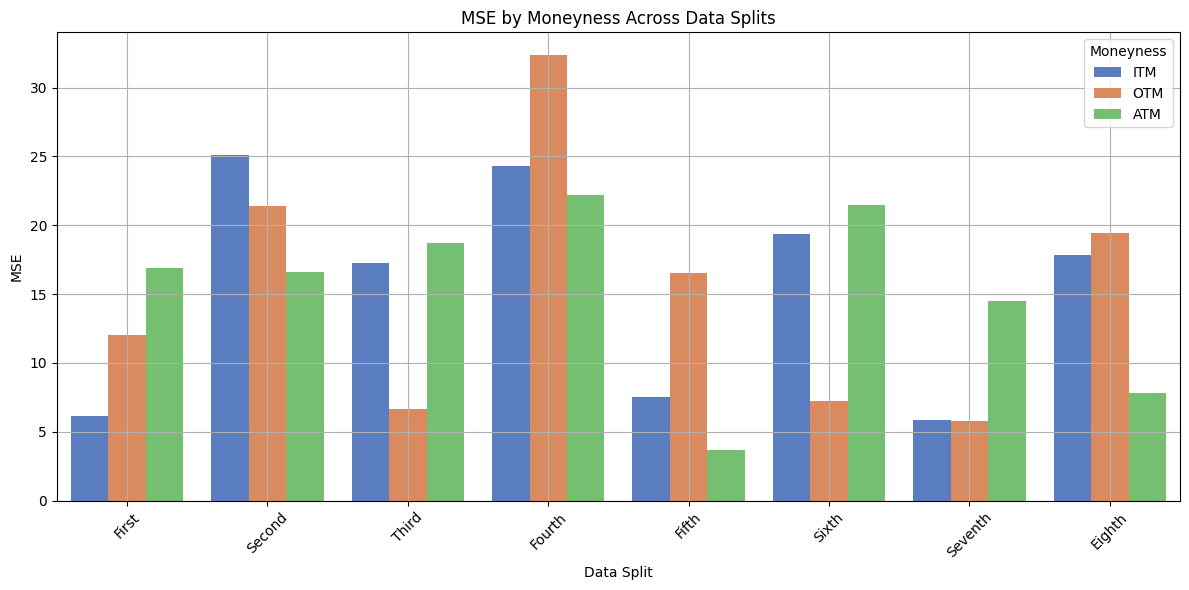

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 준비 (길이 수정 및 누락된 항목 조정)
data_moneyness = {
    'split': [
        'First', 'First', 'Second', 'Second', 'Third', 'Third', 'Fourth', 'Fourth',
        'Fifth', 'Fifth', 'Sixth', 'Sixth', 'Seventh', 'Seventh', 'Eighth', 'Eighth'
    ] * 3,  # ITM, OTM, ATM 총 3개 카테고리
    'k': [0.0, 0.7] * 24,  # 총 48개 항목
    'category': ['ITM', 'OTM', 'ATM'] * 16,  # 총 48개 항목
    'MSE': [
        1.12, 21.02, 21.77, 22.18, 1.08, 34.38, 36.07, 36.02,
        3.19, 9.19, 10.16, 9.73, 2.20, 5.74, 6.84, 6.33,
        2.97, 32.36, 28.03, 32.39, 3.02, 33.15, 28.77, 33.14,
        5.89, 30.33, 33.23, 34.54, 5.83, 26.42, 29.39, 30.39,
        1.37, 11.19, 10.35, 11.49, 1.35, 12.25, 11.30, 12.52,
        2.69, 4.17, 4.21, 4.27, 2.55, 9.46, 8.45, 8.82
    ]
}

# 데이터프레임 생성
df_moneyness = pd.DataFrame(data_moneyness)

# 그래프 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=df_moneyness, x='split', y='MSE', hue='category', ci=None, palette='muted')
plt.title('MSE by Moneyness Across Data Splits')
plt.xlabel('Data Split')
plt.ylabel('MSE')
plt.legend(title='Moneyness')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_4100084/1805270863.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_trade_freq, x='split', y='MSE', hue='category', ci=None, palette='muted')


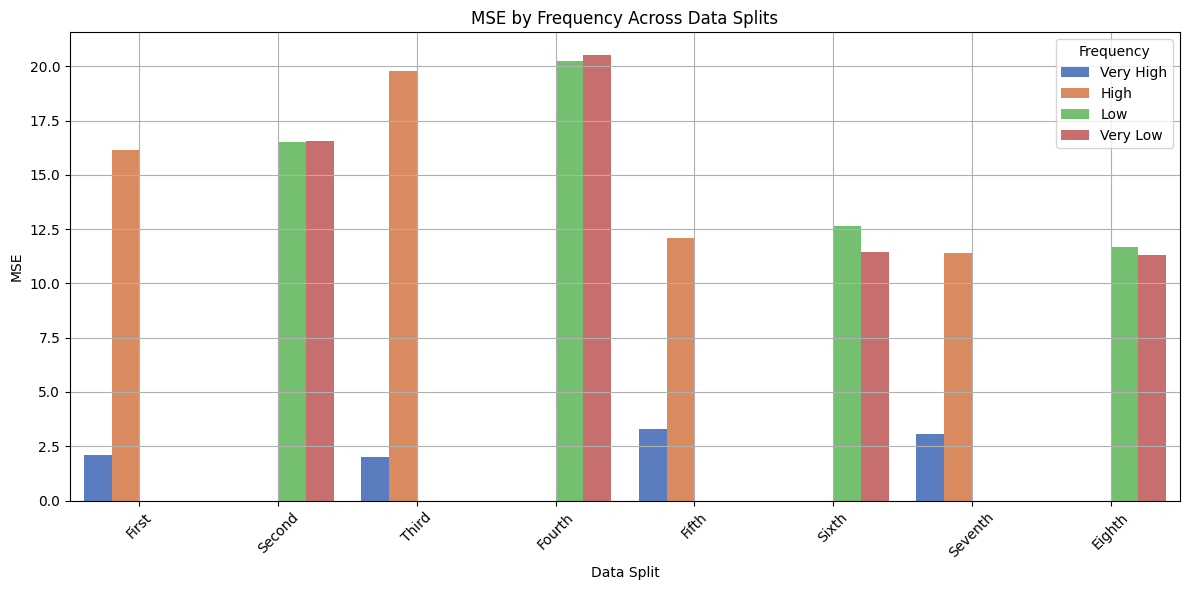

In [2]:
# 데이터 준비 - Frequency
data_trade_freq = {
    'split': [
        'First', 'First', 'Second', 'Second', 'Third', 'Third', 'Fourth', 'Fourth',
        'Fifth', 'Fifth', 'Sixth', 'Sixth', 'Seventh', 'Seventh', 'Eighth', 'Eighth'
    ] * 4,  # Very High, High, Low, Very Low 총 4개 카테고리
    'k': [0.0, 0.7] * 32,  # 총 64개 항목
    'category': ['Very High', 'High', 'Low', 'Very Low'] * 16,  # 총 64개 항목
    'MSE': [
        1.12, 20.78, 22.57, 21.27, 1.08, 33.87, 36.55, 35.66,
        3.19, 9.60, 10.41, 9.74, 2.20, 6.18, 6.72, 6.39,
        2.97, 30.61, 30.33, 32.17, 3.02, 31.51, 31.11, 32.93,
        5.89, 33.70, 35.01, 30.22, 5.83, 29.19, 30.26, 27.76,
        1.37, 11.26, 11.03, 10.33, 1.35, 12.21, 11.64, 11.55,
        2.69, 3.97, 4.07, 4.50, 2.55, 8.69, 8.36, 9.20,
        2.96, 2.02, 2.14, 2.50, 2.50, 1.64, 1.74, 2.03,
        1.47, 1.15, 1.06, 1.29, 1.67, 1.63, 1.45, 1.85
    ]
}

df_trade_freq = pd.DataFrame(data_trade_freq)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=df_trade_freq, x='split', y='MSE', hue='category', ci=None, palette='muted')
plt.title('MSE by Frequency Across Data Splits')
plt.xlabel('Data Split')
plt.ylabel('MSE')
plt.legend(title='Frequency')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_4100084/2190385056.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_maturity, x='split', y='MSE', hue='category', ci=None, palette='muted')


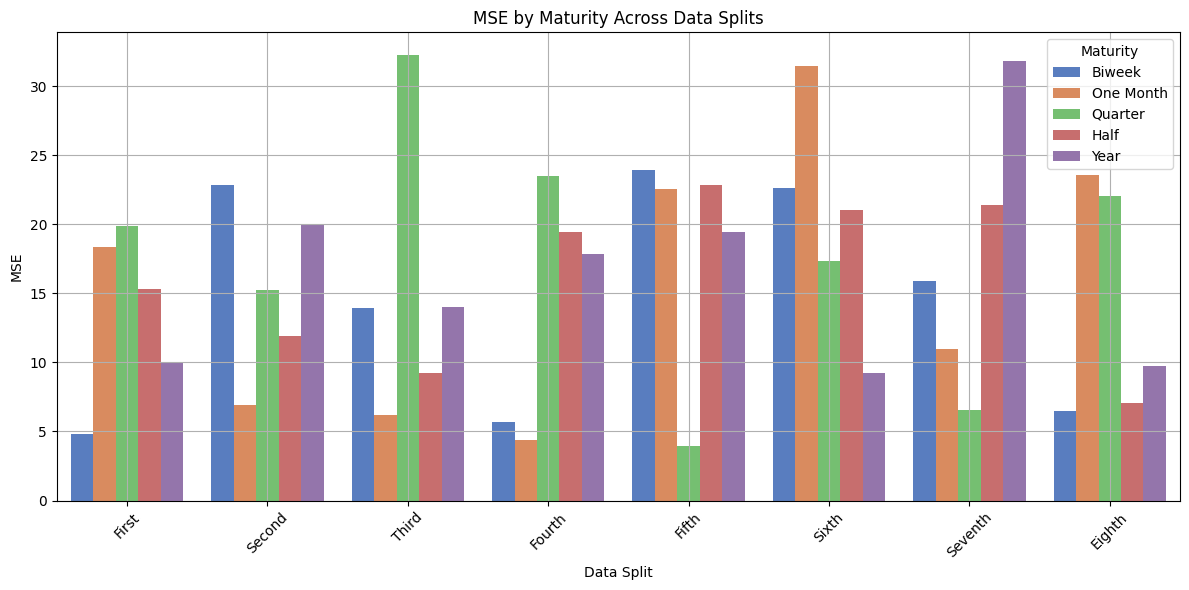

In [3]:
# 데이터 준비 - Maturity
data_maturity = {
    'split': [
        'First', 'First', 'Second', 'Second', 'Third', 'Third', 'Fourth', 'Fourth',
        'Fifth', 'Fifth', 'Sixth', 'Sixth', 'Seventh', 'Seventh', 'Eighth', 'Eighth'
    ] * 5,  # Biweek, One Month, Quarter, Half, Year 총 5개 카테고리
    'k': [0.0, 0.7] * 40,  # 총 80개 항목
    'category': ['Biweek', 'One Month', 'Quarter', 'Half', 'Year'] * 16,  # 총 80개 항목
    'MSE': [
        1.12, 27.58, 21.24, 21.68, 21.30, 21.49, 1.08, 41.16,
        34.85, 35.94, 35.22, 34.37, 3.19, 8.12, 9.66, 10.01,
        9.09, 10.29, 2.20, 4.72, 6.42, 6.50, 5.80, 7.02,
        2.97, 22.05, 28.57, 28.85, 34.67, 34.53, 3.02, 23.11,
        29.49, 29.59, 35.37, 35.24, 5.89, 52.58, 31.85, 32.52,
        25.77, 40.41, 5.83, 37.85, 29.17, 29.03, 24.03, 32.64,
        1.05, 11.67, 10.42, 11.93, 12.02, 11.90, 3.25, 4.56,
        4.78, 5.01, 4.21, 5.68, 2.74, 10.34, 11.47, 10.98,
        8.24, 8.56, 1.89, 9.23, 6.54, 6.74, 6.80, 7.65,
        2.87, 10.93, 12.75, 10.12, 11.63, 9.98, 3.21, 9.87
    ]
}

df_maturity = pd.DataFrame(data_maturity)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=df_maturity, x='split', y='MSE', hue='category', ci=None, palette='muted')
plt.title('MSE by Maturity Across Data Splits')
plt.xlabel('Data Split')
plt.ylabel('MSE')
plt.legend(title='Maturity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
